#An in depth analysis of Taylor Swift discography (Ewa Włodarczyk's version)

#used packages
library(readxl)
library(tidyverse)
library(ggplot2)
library(ggvenn)
library(RColorBrewer)
library(ggridges)
library(stringr)
library(tm)
library(wordcloud)
library(syuzhet)
library(tidytext)
library(igraph)
library(glue)
library(magick)
library(ggimage)
library(ggforce)
library(ggthemes)
library(cropcircles)
library(ggalluvial)
library(ggparallel)
library(rminer)
library(dplyr)
library(textclean)
library(SnowballC)
library(textmineR)
library(e1071)
library(parsnip)
library(rsample)
library(rpart.plot)
library(partykit)
library(gofastr)
library(caret)
library(Rtsne)
library(lsa)
library(gridExtra)
options(warn=-1)

data <- read_excel("taylor_data.xlsx")

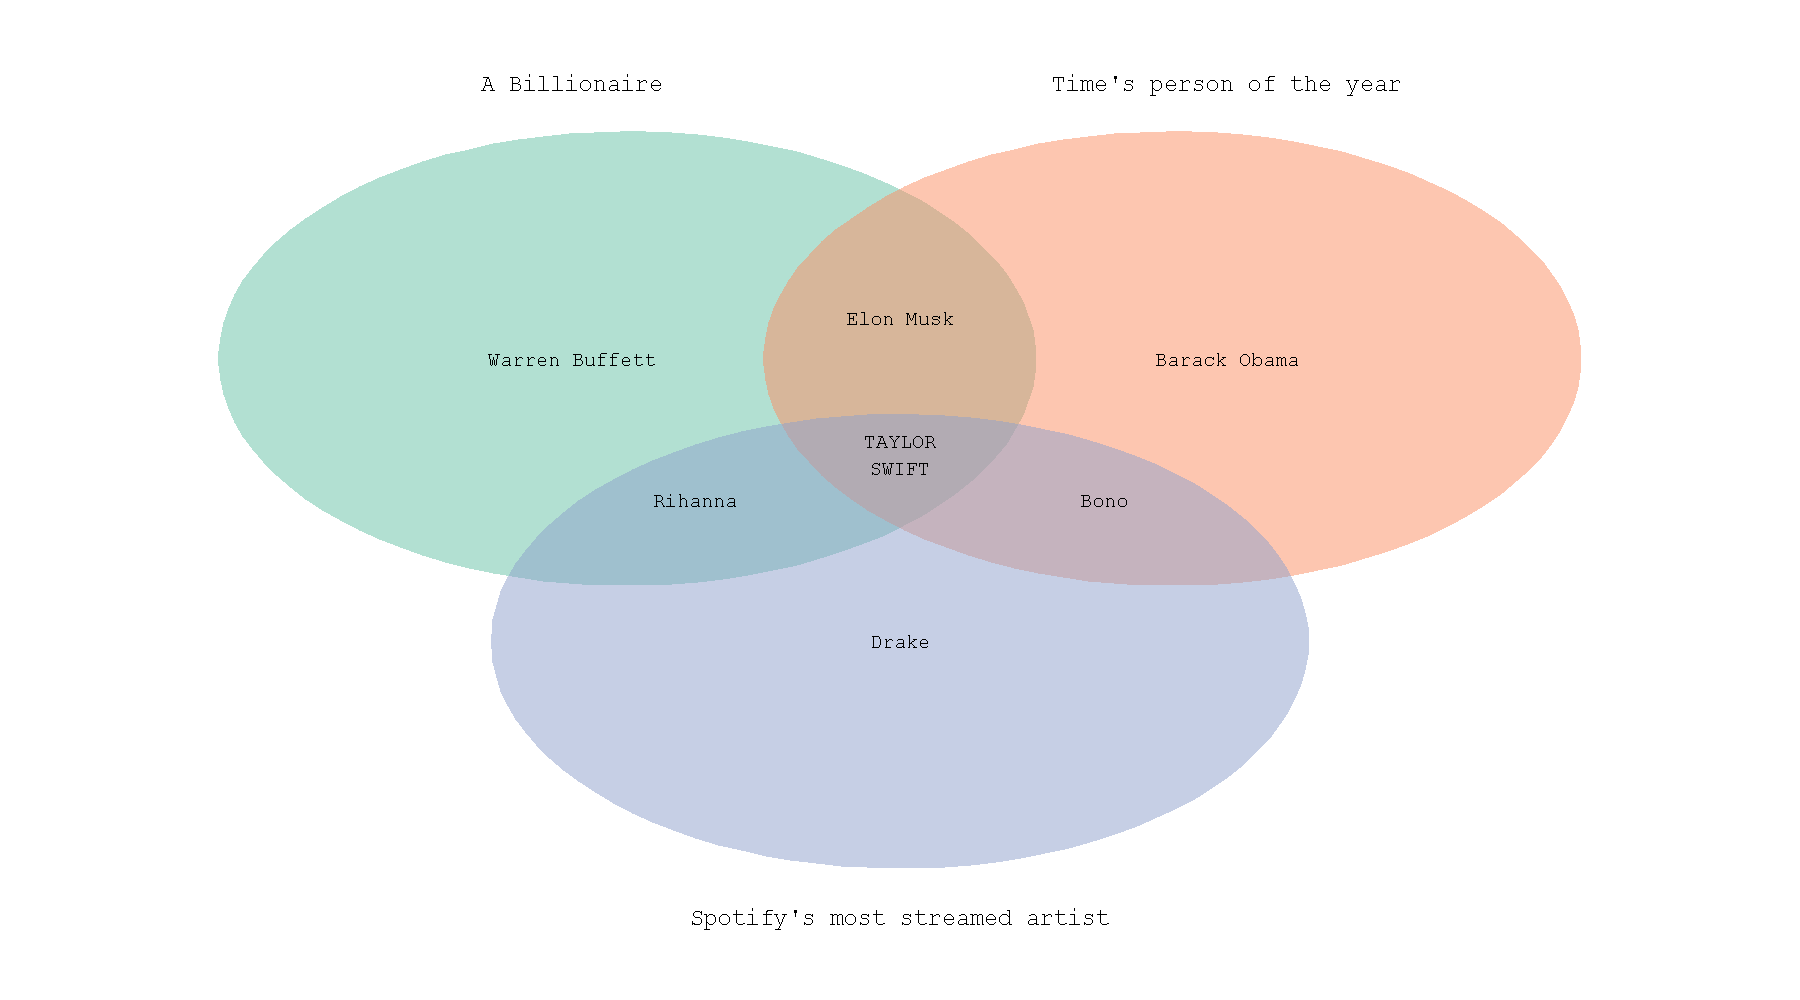

In [47]:
#1 Who is Taylor Swift?

venn_list <- tibble(value   = c('Elon Musk','Warren Buffett','TAYLOR\nSWIFT','Rihanna','Barack Obama','Bono','Drake'),
            `A Billionaire` = c(T, T, T, T, F, F,F),
            `Time's person of the year` = c(T, F, T, F, T, T, F),
            `Spotify's most streamed artist` = c(F, F, T, T, F, T,T)) 
#venn diagram
p<-ggplot(venn_list, aes(A = `A Billionaire`, B = `Time's person of the year`,C=`Spotify's most streamed artist`)) +
  geom_venn(label = venn_list$value,stroke_linetype='blank',fill_color = brewer.pal(name="Set2",n=3), text_size=5) + theme_void()

#function for changing font in venn diagram
venn_font <- function(p, font)
{
  
  grep_grob <- function(gt, lab){
    which(sapply(gt, function(x) grepl(lab, x$name)))
  }
  
  p2 <- ggplot_gtable(ggplot_build(p))
  mygrobs <- p2$grobs
  panel_grob <- mygrobs[[grep_grob(mygrobs, "panel")]]
  venn_grob <- panel_grob$children[[grep_grob(panel_grob$children, "venn")]]
  text_grob <- venn_grob$children[grep_grob(venn_grob$children, "text")]
  text_grob <- do.call(grid::gList, 
                       lapply(text_grob, 
                              function(x) {x$gp$fontfamily <- font; 
                              x}))
  venn_grob$children[grep_grob(venn_grob$children, "text")] <- text_grob
  panel_grob$children[[grep_grob(panel_grob$children, "venn")]] <- venn_grob
  mygrobs[[grep_grob(mygrobs, "panel")]] <- panel_grob
  p2$grobs <- mygrobs
  grid::grid.newpage()
  grid::grid.draw(p2)
  
}

#final venn diagram
options(repr.plot.width = 18, repr.plot.height = 10)
venn_font(p, font = "mono")


#She is the first simultaneous Billionaire,Time's person of the year and Spotify's most streamed artist

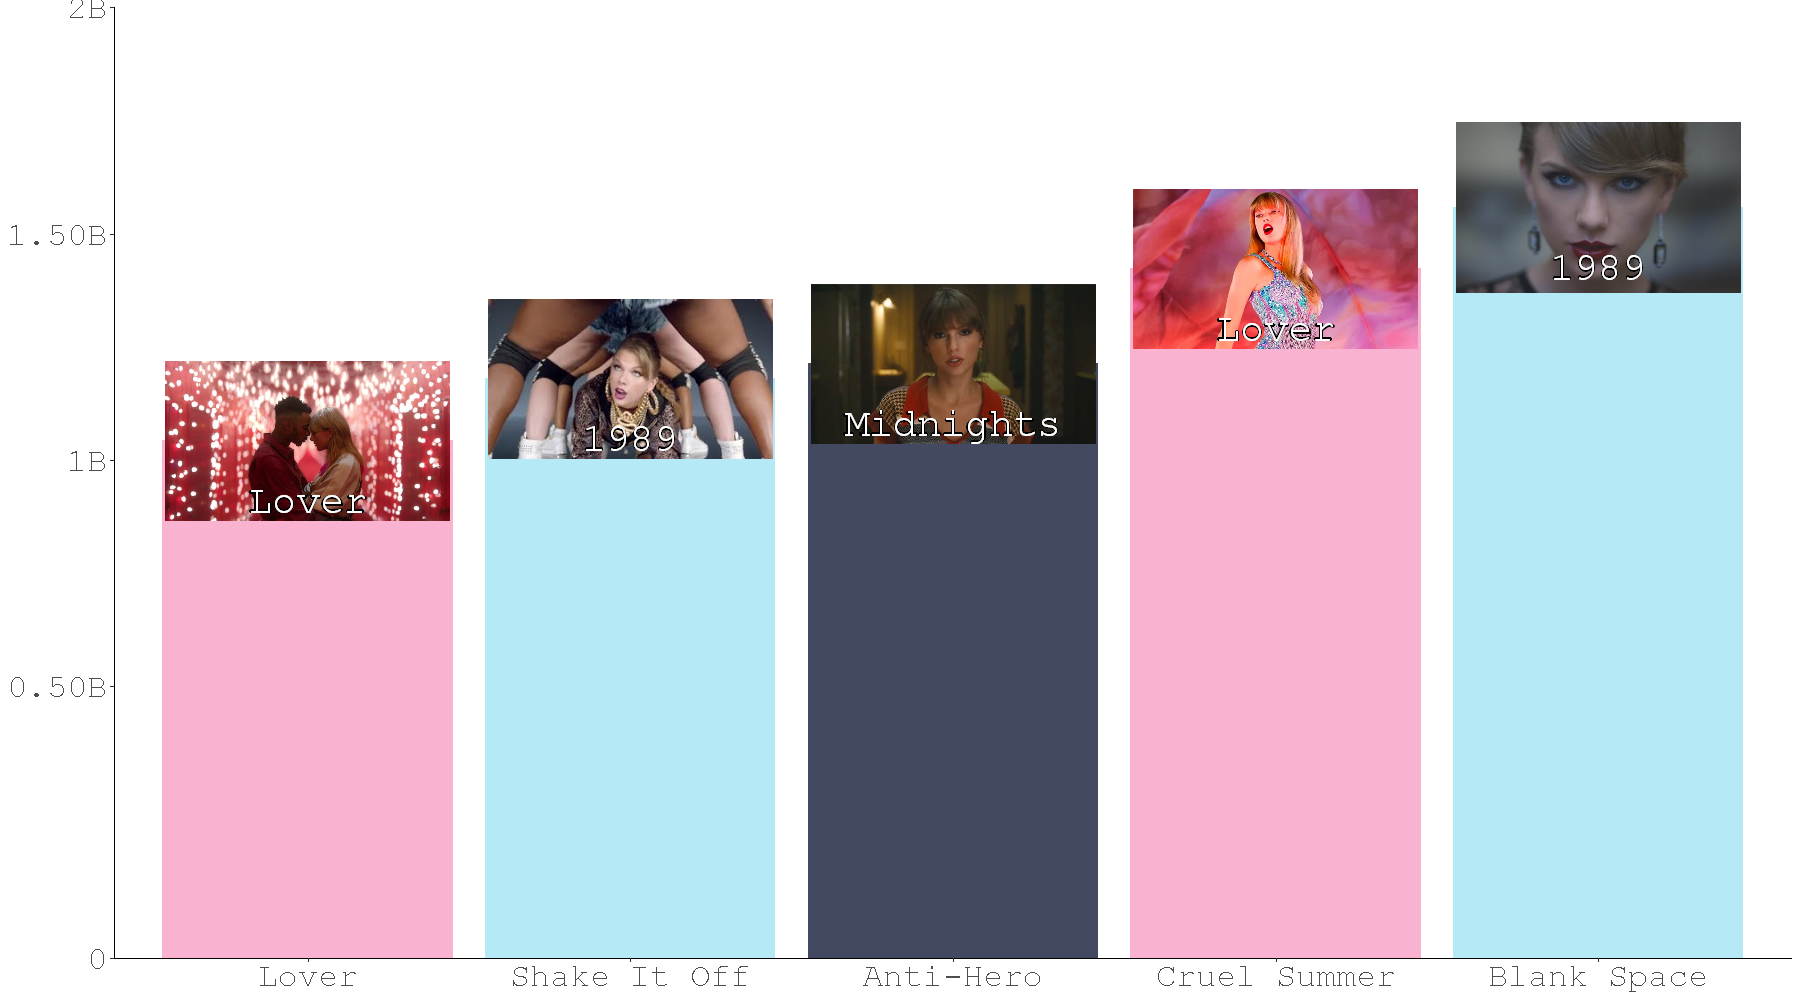

In [48]:
#2 What are Taylor's most streamed songs? (as of 12/23)

#data for graph (ordering songs)
top_streamed<-subset(data, select=c(track_name, streams))%>%arrange(streams)%>%tail(5)
top_streamed$track_name<-reorder(top_streamed$track_name,top_streamed$streams,decreasing=TRUE)

#adding pictures of song videos
d <- data.frame(
  stream = c( 1143756527, 1280584111, 1313052618, 1524247903, 1659548488),
  song = c('Lover', 'Shake It Off', 'Anti-Hero','Cruel Summer', 'Blank Space'),
  image = c(
    "https://media.pitchfork.com/photos/5d5ed7a01ce1350009a5d656/16:9/w_1280,c_limit/Taylor-Swift-Lover.jpg",
  "https://i.ytimg.com/vi/cJHt8ecTG4w/mqdefault.jpg",
  "https://consequence.net/wp-content/uploads/2022/10/taylor-swift-anti-hero.jpeg",
  "https://themusicuniverse.com/wp-content/uploads/2023/09/taylorswifterastourfilm.jpg",
  "https://www.udiscovermusic.com/wp-content/uploads/2022/07/taylor-swift-blank-space-youtube-views-1000x600.jpg"
    ))

#bar plot
ggplot(d, aes(reorder(song, stream), stream, fill=reorder(song, stream))) +geom_col()+ geom_image(aes(image=image), size=.3, position = "stack")+
  theme_tufte()+scale_fill_manual(values=c('#f9b2d0','#b5e9f6','#434961','#f9b2d0','#b5e9f6'))+
  theme(axis.title = element_blank(), legend.position = 'blank',panel.grid = element_blank(),axis.line = element_line(colour = "black"),
text=element_text(family='mono', size=30))+
scale_y_continuous(limits = c(0, 2100000000), breaks = c(0,600000000,1100000000, 1600000000, 2100000000), 
                   labels=c('0'='0','600000000'='0.50B','1100000000'='1B','1600000000'='1.50B','2100000000'='2B'),expand = c(0, 0))+
  geom_text(label=c('Lover', '1989','Midnights','Lover','1989'),vjust=3,family='mono', size=10,fontface="bold", color='black')+
  geom_text(label=c('Lover', '1989','Midnights','Lover','1989'),vjust=3,family='mono', size=10, color='white')


#Her top 5 most streamed songs, all of which have above one billion streams on Spotify are:
#Lover, Shake it Off, Anti-hero, Cruel Summer and Blank Space (from her three pop albums: Lover, 1989 and Midnights)

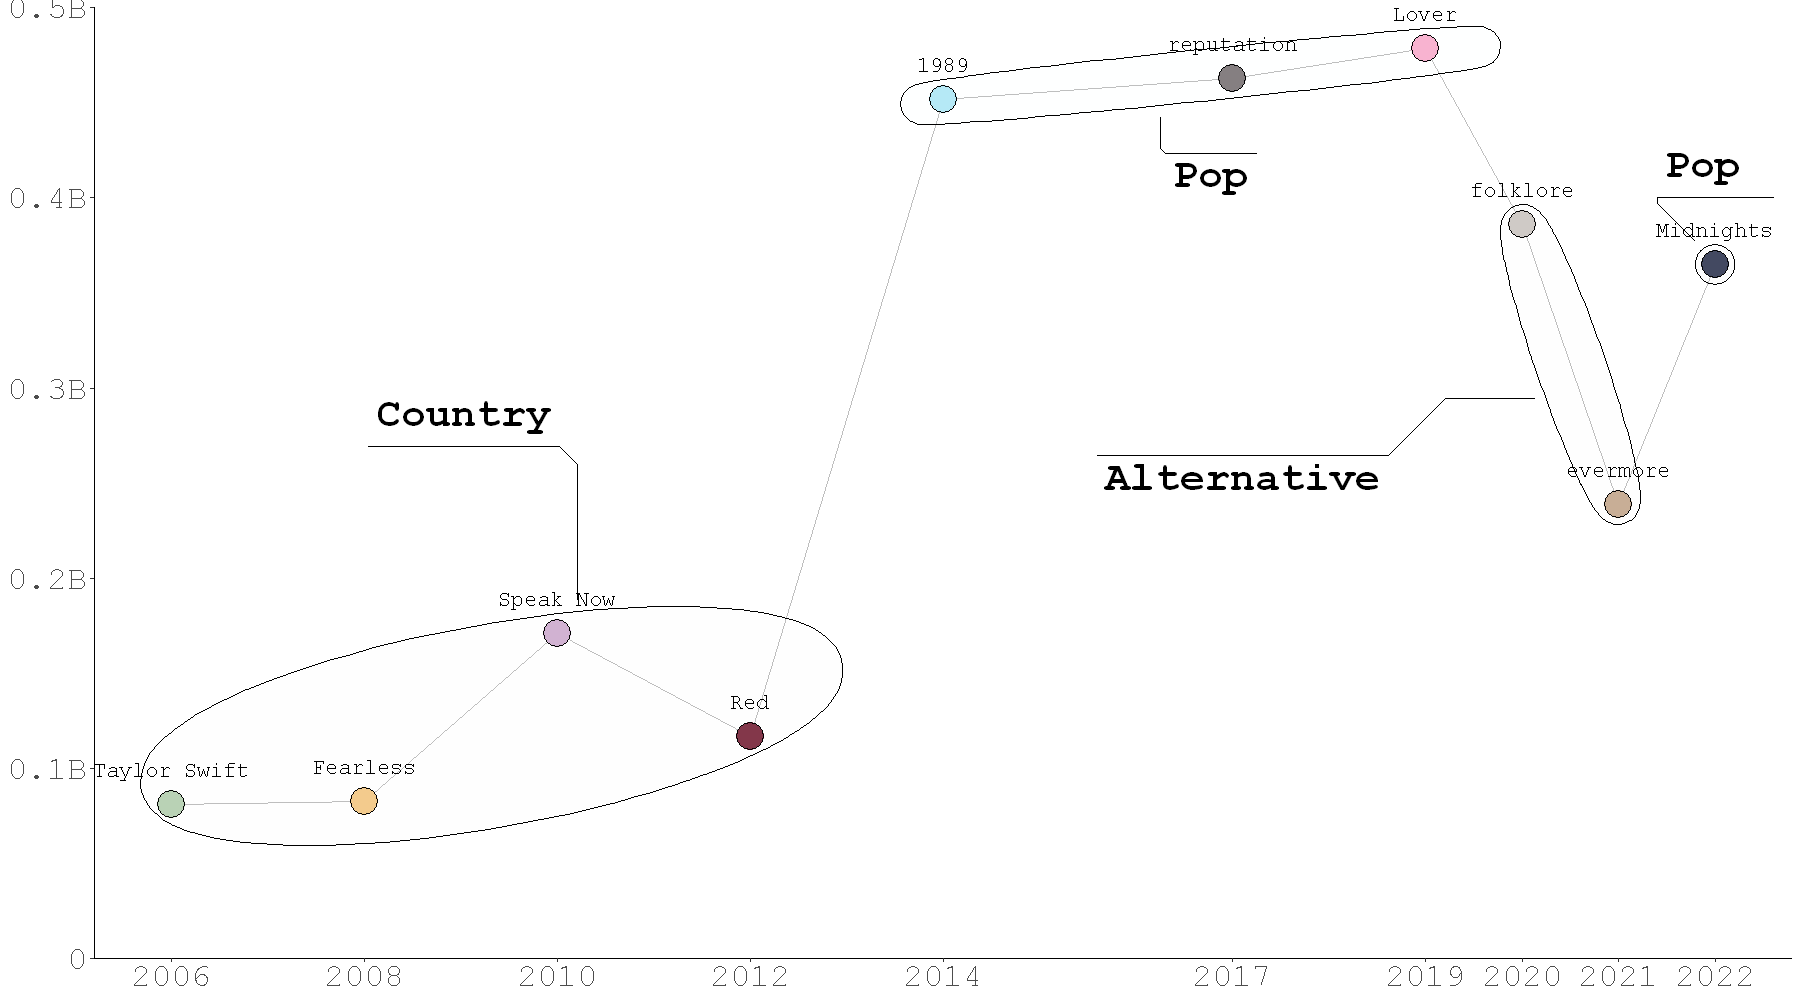

In [13]:
#3 What are Taylor's album genres and their average amount of streams?

#filtering out re-recorings
data_<-data%>%filter(!album_name %in% c('Red (Taylor\'s Version)', 'Fearless (Taylor\'s Version)'))

#data for graph (average streams, adding genres and recording years)
album_stream<-data_%>%group_by(album_name)%>%mutate(avg_album_stream=mean(streams))%>%mutate(sum_album_stream=sum(streams))%>%
  mutate(album_year=substr(album_release, 1, 4))%>%
  subset(select=c(album_name, avg_album_stream, album_year,sum_album_stream))%>%unique()
album_stream<-tibble::rownames_to_column(album_stream, "album_nr")
album_stream$genre<-c('Country','Country','Country','Country','Pop','Pop','Pop','Alternative','Alternative','Pop ')
album_stream$album_year[9]<-'2021'

#line plot with custom colors for albums and annotated genres
ggplot(album_stream, aes(x=as.numeric(album_year), y=avg_album_stream, group=1, fill=as.factor(as.numeric(album_nr))))+
  geom_line(color="grey") +
 theme_tufte()+
  theme(axis.title = element_blank() ,legend.position = 'blank',axis.line = element_line(colour = "black"),
  text=element_text(family='mono', size=30))+
  scale_fill_manual(values=c('#b9d2b5','#f4cb8d','#d1b2d2','#823549','#b5e9f6','#847e80','#f9b2d0','#cfcac6','#c8ae95','#434961'))+
  geom_text(label=album_stream$album_name, vjust =-2,check_overlap = T,family='mono', size=5.5)+
  scale_y_continuous(limits = c(0, 500000000), breaks = c(0,100000000,200000000,300000000,400000000,500000000), 
                     labels=c('0'='0','100000000'='0.1B','200000000'='0.2B','300000000'='0.3B','400000000'='0.4B','500000000'='0.5B'),expand = c(0, 0))+
  scale_x_continuous(breaks=c(2006,2008,2010,2012,2014,2017,2019,2020,2021,2022),labels = c('2006','2008','2010','2012','2014','2017','2019','2020','2021','2022'))+
  geom_point(shape=21, size=9)+
  geom_mark_ellipse(aes(label = album_stream$genre, filter=genre=='Country'), alpha=0.01,label.family='mono',label.fontsize=30,label.buffer = unit(40, 'mm')  )+
  geom_mark_ellipse(aes(label = album_stream$genre, filter=genre=='Pop'), alpha=0.01,label.family='mono',label.fontsize=30 )+
  geom_mark_ellipse(aes(label = album_stream$genre, filter=genre=='Alternative'), alpha=0.01,label.family='mono',label.fontsize=30,
                    label.buffer = unit(40, 'mm') )+
  geom_mark_ellipse(aes(label = album_stream$genre, filter=genre=='Pop '), alpha=0.01,label.family='mono',label.fontsize=30)


#Looking at the average amount of streams that songs from each album got, their genres and years of release we can see that
#after the mild success of her country albums there is a huge jump in popularity with her first pop album 1989 
#and overall we can see that her pop records are listened to the most, 
#however her two alternative records: folklore and evermore did not underperform, 
#but both have been released fairly recently and need some time to acquire more streams. 


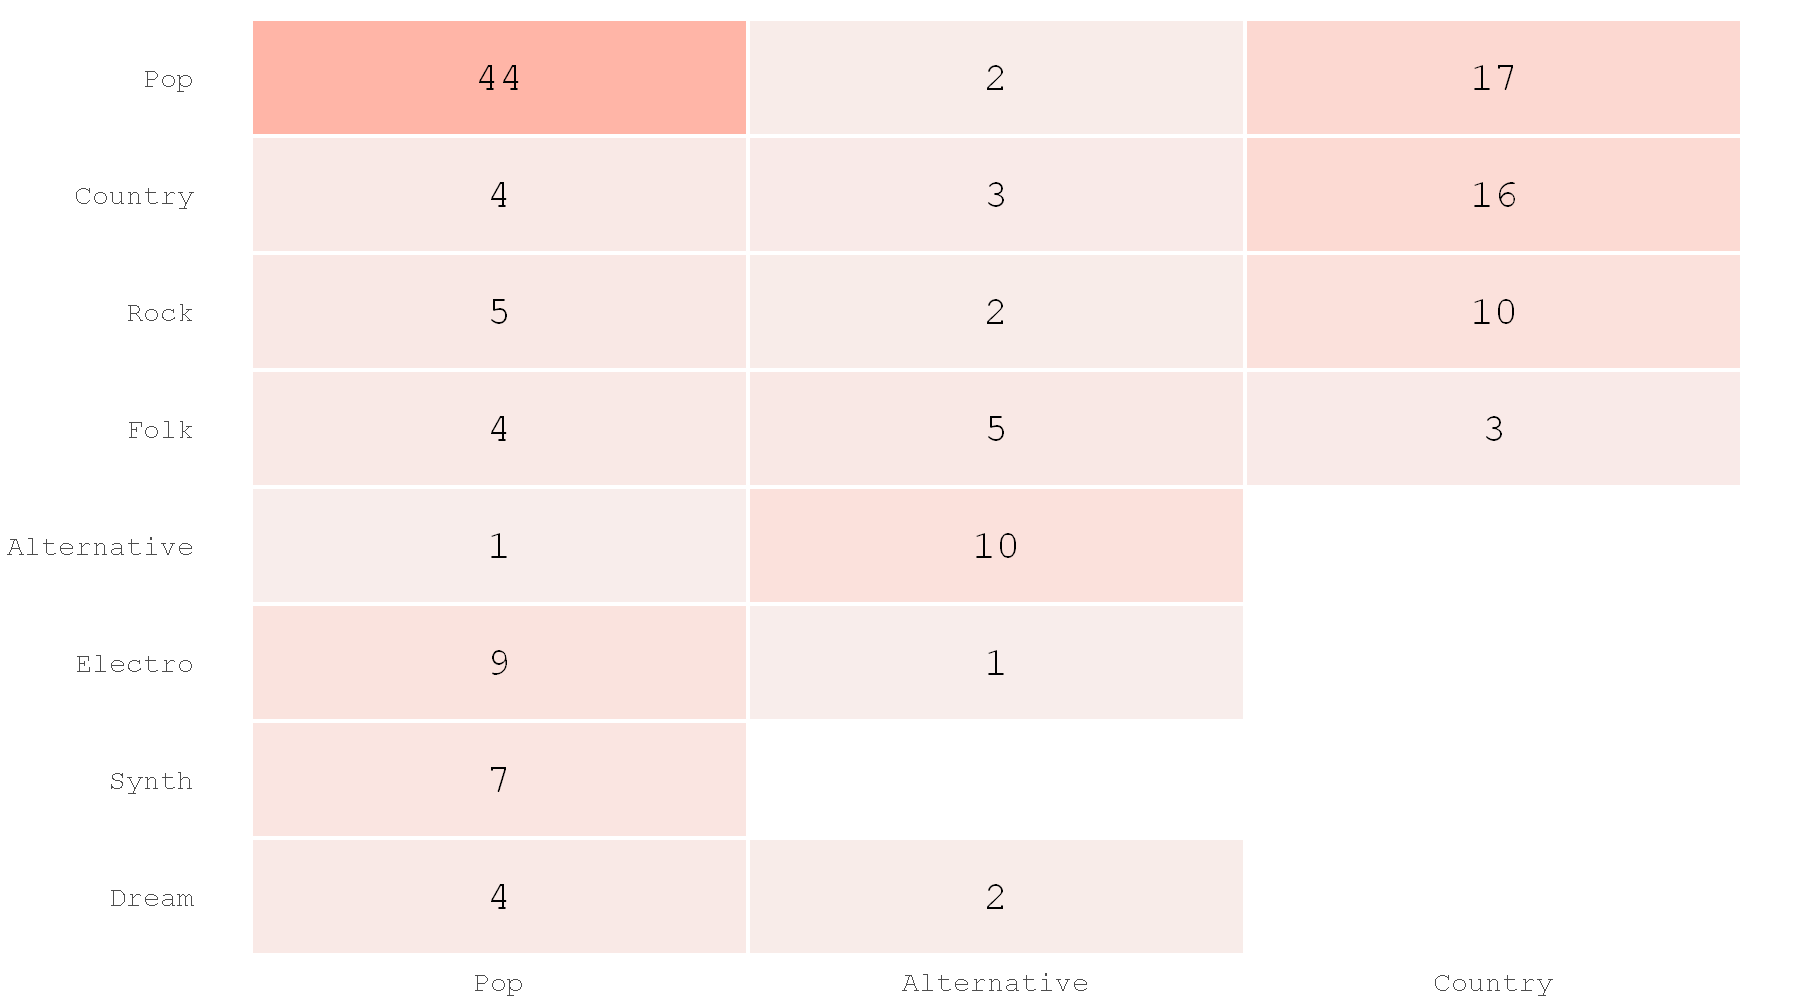

In [14]:
#4 What genres are Taylor's songs?

#data for graph (cleaning genres data)
data_$genre2[data_$genre2 == "NA"] <- NA
genre<-data_%>%count(genre1, genre2)%>%mutate(genre3 = coalesce(genre2,genre1))%>%group_by(genre3)%>%mutate(n2 = sum(n))%>%filter(n2>5)
genre$genre2[is.na(genre$genre2)] = ""

#customized heatmap
ggplot(genre, aes(reorder(genre$genre1,genre$n2), reorder(genre$genre3,genre$n2), fill=n)) + 
  geom_tile(color = "white",lwd = 1.5,linetype = 1)+theme_minimal()+ 
  theme(axis.title = element_blank(),panel.grid = element_blank() ,text=element_text(family='mono', size=25),
        legend.position='none')+
  geom_text(label=paste(genre$n),check_overlap = T,family='mono', size=10)+
  scale_fill_gradient(low ='#f8edeb',high ='#ffb5a7')

#Most of Taylor's songs are Pop, then Country pop and Country, 
#but she also have some Alternative, Country Rock and Electro Pop records

Picking joint bandwidth of 0.044

Picking joint bandwidth of 0.0821



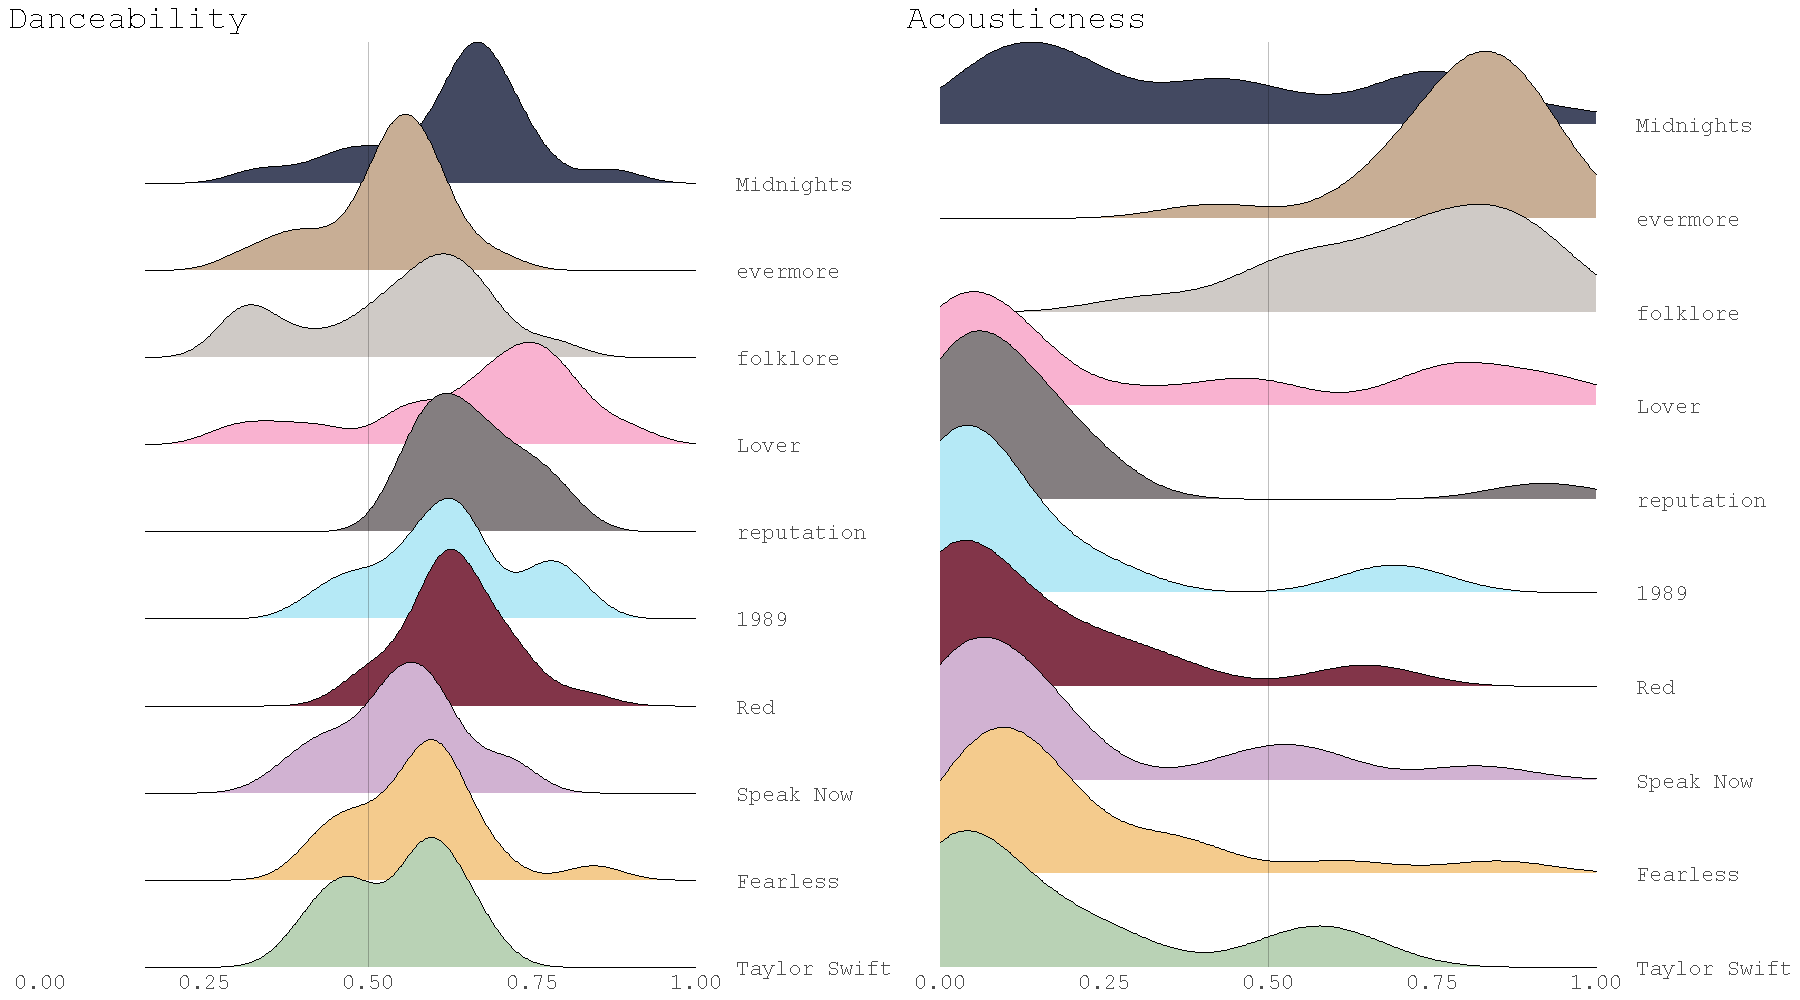

In [46]:
#5 How Taylor's style differs from album to album? (based on album's danceability and acousticness)

#ridgeline plot for danceability with custom colors for albums
p1<-ggplot(data_, aes(x = danceability, y = as.factor(as.numeric(album_nr)), fill = as.factor(as.numeric(album_nr)))) +
  geom_density_ridges() + geom_vline(xintercept = 0.5, size = 0.5, color = "black", alpha=0.25)+
  theme_ridges() + theme_minimal()+theme(axis.title = element_blank(), legend.position = 'blank',panel.grid = element_blank(), text=element_text(family='mono', size=20))+
ggtitle("Danceability") +
scale_fill_manual(values=c('#b9d2b5', '#f4cb8d','#d1b2d2','#823549','#b5e9f6','#847e80','#f9b2d0','#cfcac6','#c8ae95','#434961'))+
  scale_y_discrete(labels=c('1'='Taylor Swift', '2'='Fearless','3'='Speak Now', '4'='Red', '5'='1989',
                            '6'='reputation', '7'='Lover', '8'='folklore', '9'='evermore', '10'='Midnights'),position='right',expand = c(0, 0))+
  scale_x_continuous(limits = c(0, 1), breaks = c(0,0.25, 0.5, 0.75,1))

#ridgeline plot for acousticness with custom colors for albums
p2<-ggplot(data_, aes(x = acousticness, y = as.factor(as.numeric(album_nr)), fill = as.factor(as.numeric(album_nr)))) +
  geom_density_ridges() + geom_vline(xintercept = 0.5, size = 0.5, color = "black", alpha=0.25)+
  theme_ridges() + theme_minimal()+theme(axis.title = element_blank(), legend.position = 'blank',panel.grid = element_blank(), text=element_text(family='mono', size=20))+
ggtitle("Acousticness")+  
scale_fill_manual(values=c('#b9d2b5', '#f4cb8d','#d1b2d2','#823549','#b5e9f6','#847e80','#f9b2d0','#cfcac6','#c8ae95','#434961'))+
  scale_y_discrete(labels=c('1'='Taylor Swift', '2'='Fearless','3'='Speak Now', '4'='Red', '5'='1989',
                            '6'='reputation', '7'='Lover', '8'='folklore', '9'='evermore', '10'='Midnights'),expand = c(0, 0), position='right')+
  scale_x_continuous(limits = c(0, 1), breaks = c(0,0.25, 0.5, 0.75,1))
grid.arrange(p1, p2, nrow = 1)

#For acousticness the peaks of first seven albums are on the lower end of the scale 
#but we can see other smaller peaks at the higher end that are growing and evolving 
#until her two alternative albums with high peaks and then midnights is more balanced 
#with songs that have varying level of acousticness. 
#For danceability, we can see that all of Taylor’s albums are fairly danceable, 
#with peaks that are fluctuating, going up and down and notably 
#we can also see second peaks with 1989 a pop album with high danceability 
#and folklore a sad alternative record with low danceability peak. 

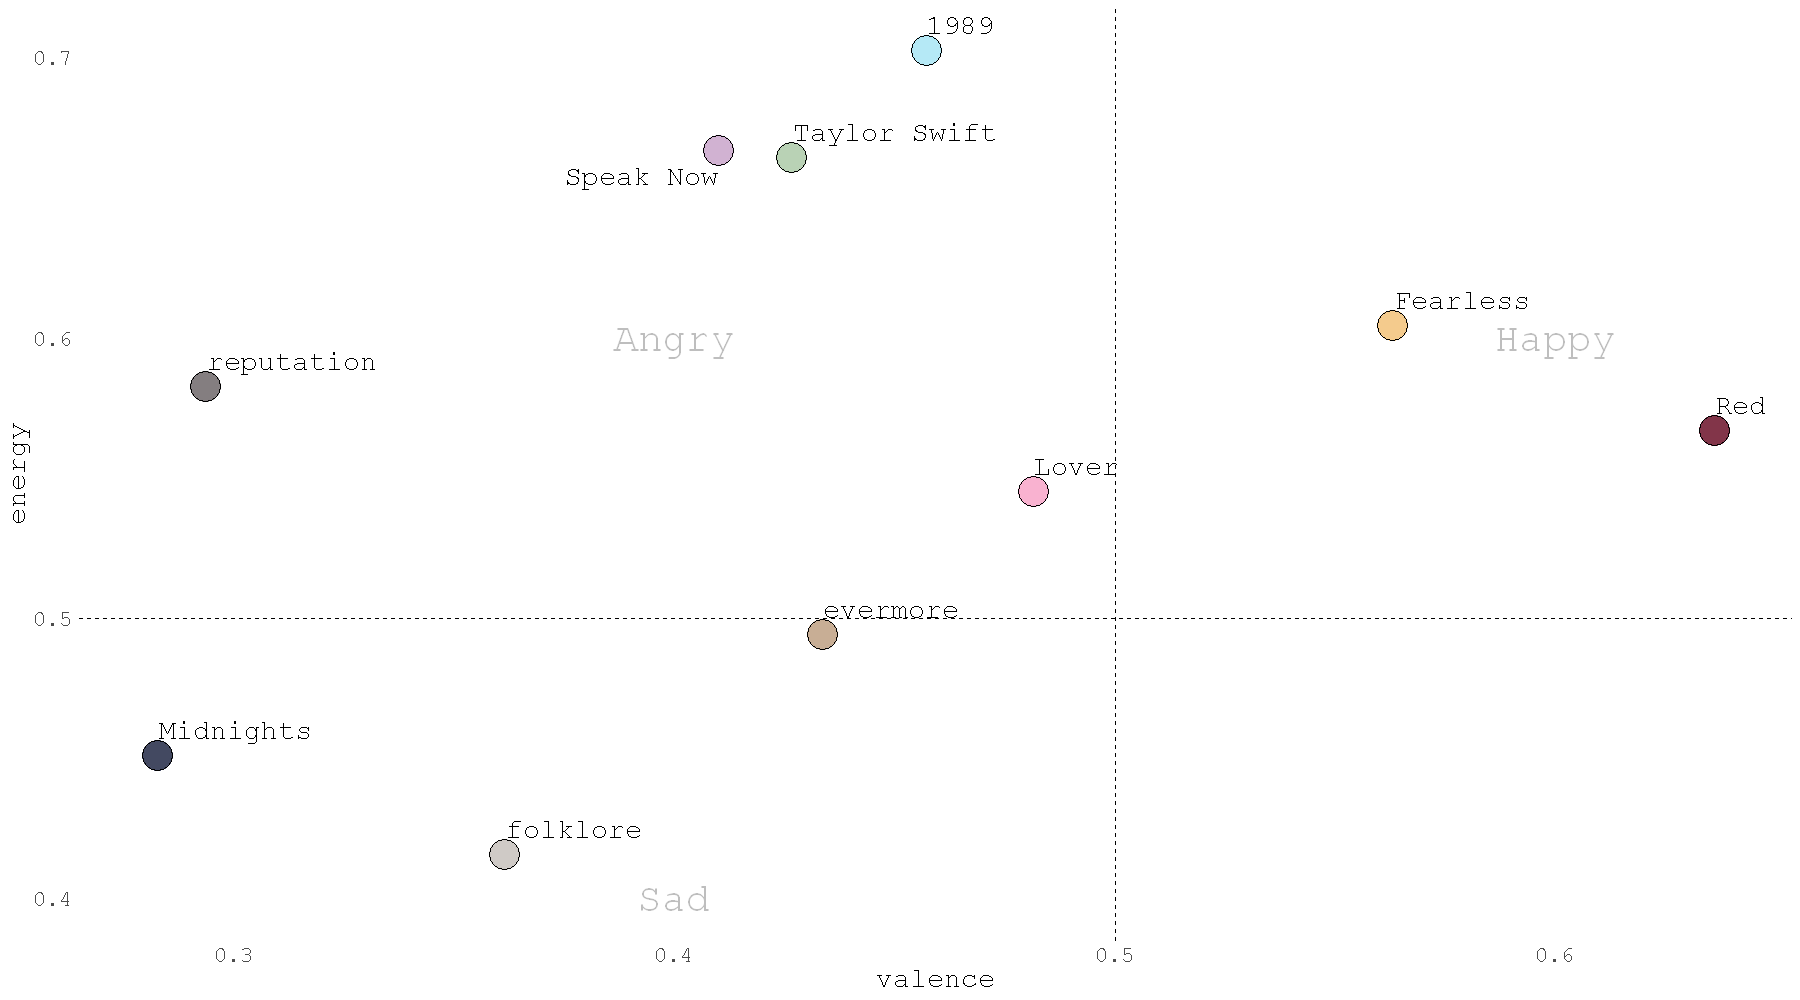

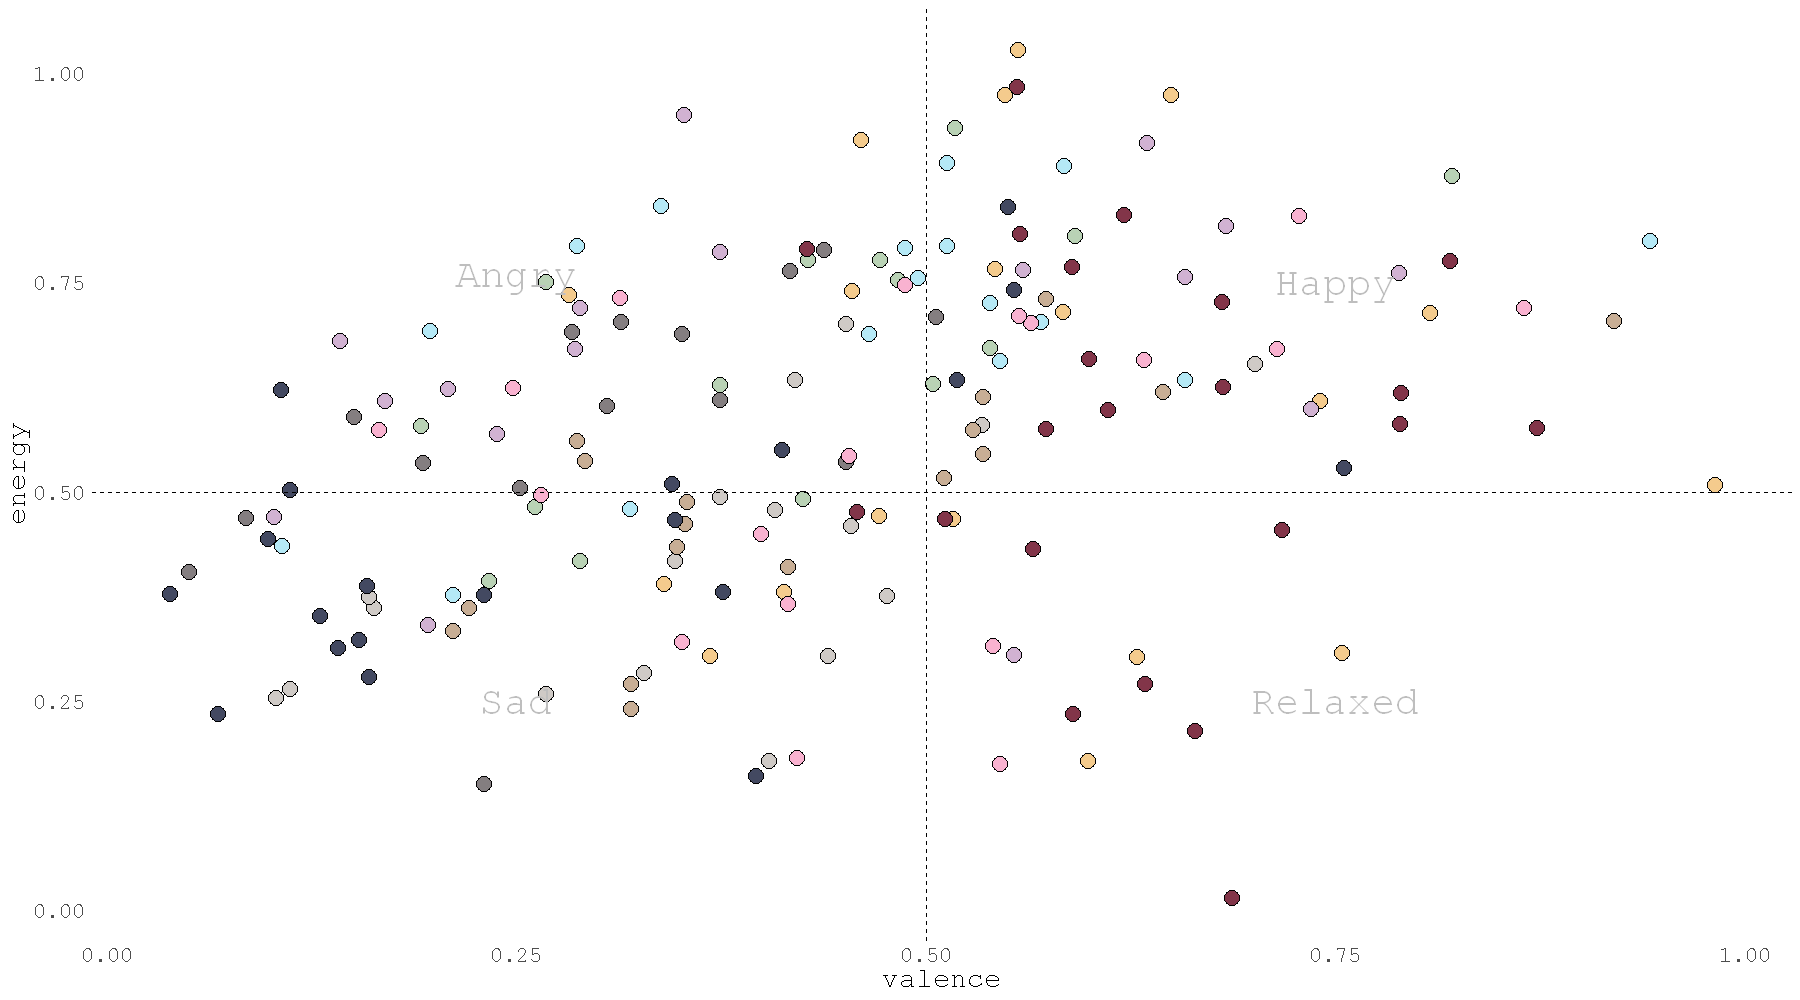

In [23]:
#6 How do Taylor's albums' and songs' music energy and positiveness look like?

#data for graph (averge values for albums)
style<-data_%>%group_by(album_name)%>%mutate(energy=mean(energy))%>%mutate(valence=mean(valence))

#additional changes for labels
style <- style %>% 
  dplyr::mutate(label_above = ifelse(album_name %in% c('Speak Now'), "", album_name),
                label_below = ifelse(album_name %in% c('Speak Now'), album_name, ""))

#x,y axis plot of music energy and positiveness for mean album values with custom album colors
ggplot(data=style, aes(x=valence,y=energy,fill=as.factor(as.numeric(album_nr))))+
  geom_point(shape=21, color="black", size=10)+
  theme_minimal()+
  scale_fill_manual(values=c('#b9d2b5','#f4cb8d' ,'#d1b2d2','#823549','#b5e9f6','#847e80','#f9b2d0','#cfcac6','#c8ae95','#434961'))+
  geom_text(label=style$label_above, vjust =-1,hjust=-0.01,check_overlap = F,family='mono', size=7)+
  geom_text(label=style$label_below, vjust =2,hjust=+1,check_overlap = F,family='mono', size=7)+
  theme( legend.position = 'blank',panel.grid = element_blank(),
       text=element_text(family='mono', size=20))+
  geom_hline(yintercept=0.5,linetype="dashed")+geom_vline(xintercept=0.5,linetype="dashed")+
  ggplot2::annotate("text", x = 0.4, y = 0.4,label = "Sad", family="mono", size=10, color='grey')+
  ggplot2::annotate("text", x = 0.4, y = 0.6,label = "Angry", family="mono", size=10, color='grey')+
  ggplot2::annotate("text", x = 0.6, y = 0.6,label = "Happy", family="mono", size=10, color='grey')

#x,y axis plot of music energy and positiveness for song values with custom album colors
ggplot(data=data_, aes(x=valence,y=energy,fill=as.factor(as.numeric(album_nr))))+
  geom_point(shape=21, color="black", size=5)+
  theme_minimal()+
  scale_fill_manual(values=c('#b9d2b5','#f4cb8d' ,'#d1b2d2','#823549','#b5e9f6','#847e80','#f9b2d0','#cfcac6','#c8ae95','#434961'))+
  theme(legend.position = 'blank',panel.grid = element_blank(),
         text=element_text(family='mono', size=20))+
  geom_hline(yintercept=0.5,linetype="dashed")+geom_vline(xintercept=0.5,linetype="dashed")+
  ggplot2::annotate("text", x = 0.25, y = 0.25,label = "Sad", family="mono", size=10, color='grey')+
  ggplot2::annotate("text", x = 0.25, y = 0.76,label = "Angry", family="mono", size=10, color='grey')+
  ggplot2::annotate("text", x = 0.75, y = 0.75,label = "Happy", family="mono", size=10, color='grey')+
  ggplot2::annotate("text", x = 0.75, y = 0.25,label = "Relaxed", family="mono", size=10, color='grey')


#Looking at album’s music emotional tone we can see that 
#songs with high energy and high valence, meaning musical positiveness are considered happy song, 
#those with low energy and negative – sad and song that have high energy and are negative are considered to have an angry tone. 
#We can see that most of Taylor’s album fall under angry, however we do have some sad and happy records. 
#That is not to say that all of Taylor’s songs are angry, even though some definitely are, 
#I would rather classify them are being upbeat, but having a pretty sad theme

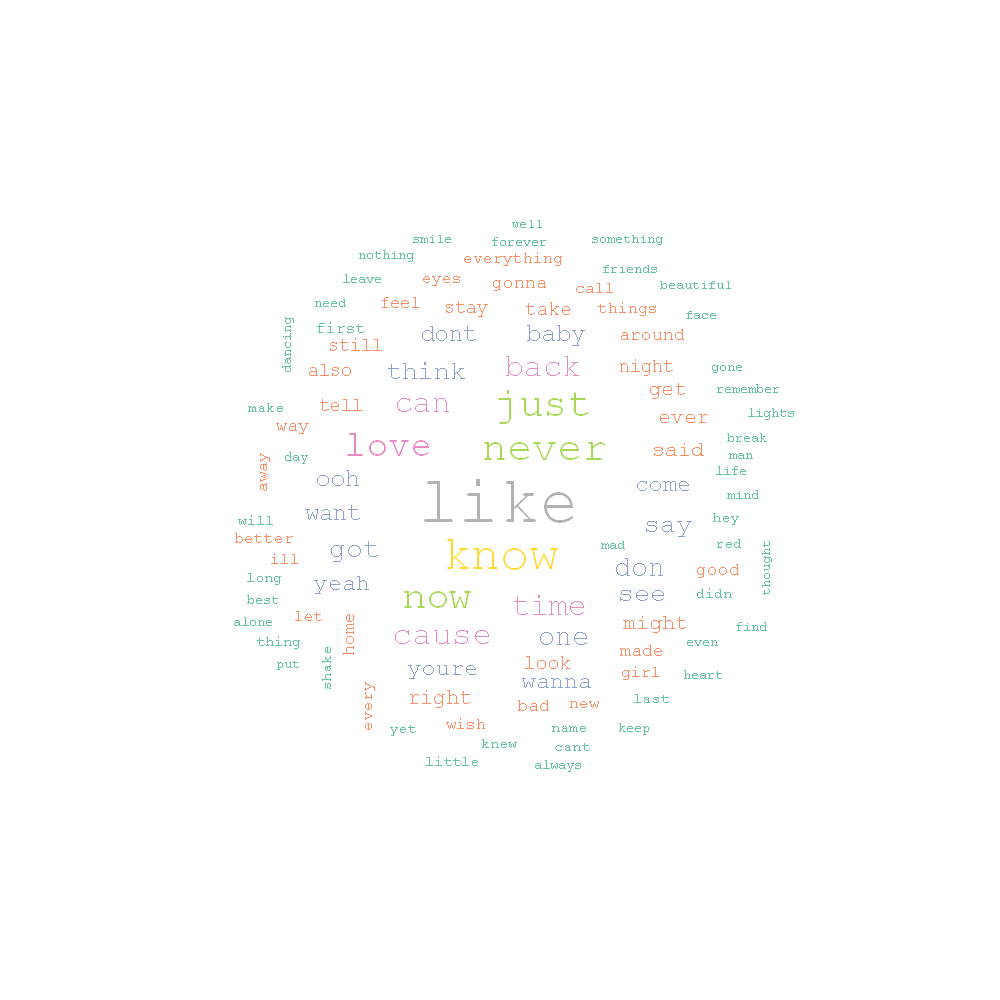

In [31]:
#7 What are Taylor's favourite (frequently used) words? 

#data for graph (cleaning lyrics, transforming to term document matrix with words frequency)
lyrics_text <- data_$lyrics
lyrics_text<- gsub('[[:punct:]]+','', lyrics_text)
lyrics_text<- gsub('([[:alpha:]])1+', '', lyrics_text)
docs <- Corpus(VectorSource(lyrics_text))
docs <- tm_map(docs, content_transformer(tolower))
docs <- tm_map(docs, removeWords, stopwords('english'))
tdm <- TermDocumentMatrix(docs)
m <- as.matrix(tdm)
word_freqs = sort(rowSums(m), decreasing=TRUE)
lyrics_wc_df <- data.frame(word=names(word_freqs), freq=word_freqs)
lyrics_wc_df <- lyrics_wc_df[1:300,]

#wordcloud
wordcloud(words = lyrics_wc_df$word, freq = lyrics_wc_df$freq,
          min.freq = 1,family='mono',text_size=200,
          max.words=100, random.order=FALSE, 
          colors=brewer.pal(name="Set2",n=8))

#We can see that “like” appears the most frequently in her songs, 
#followed by ‘know’, ‘never’, ‘just’ and ‘now’. 
#We would also often hear ‘love’, ‘time’, ‘can’, ‘back’ and ‘cause’. 


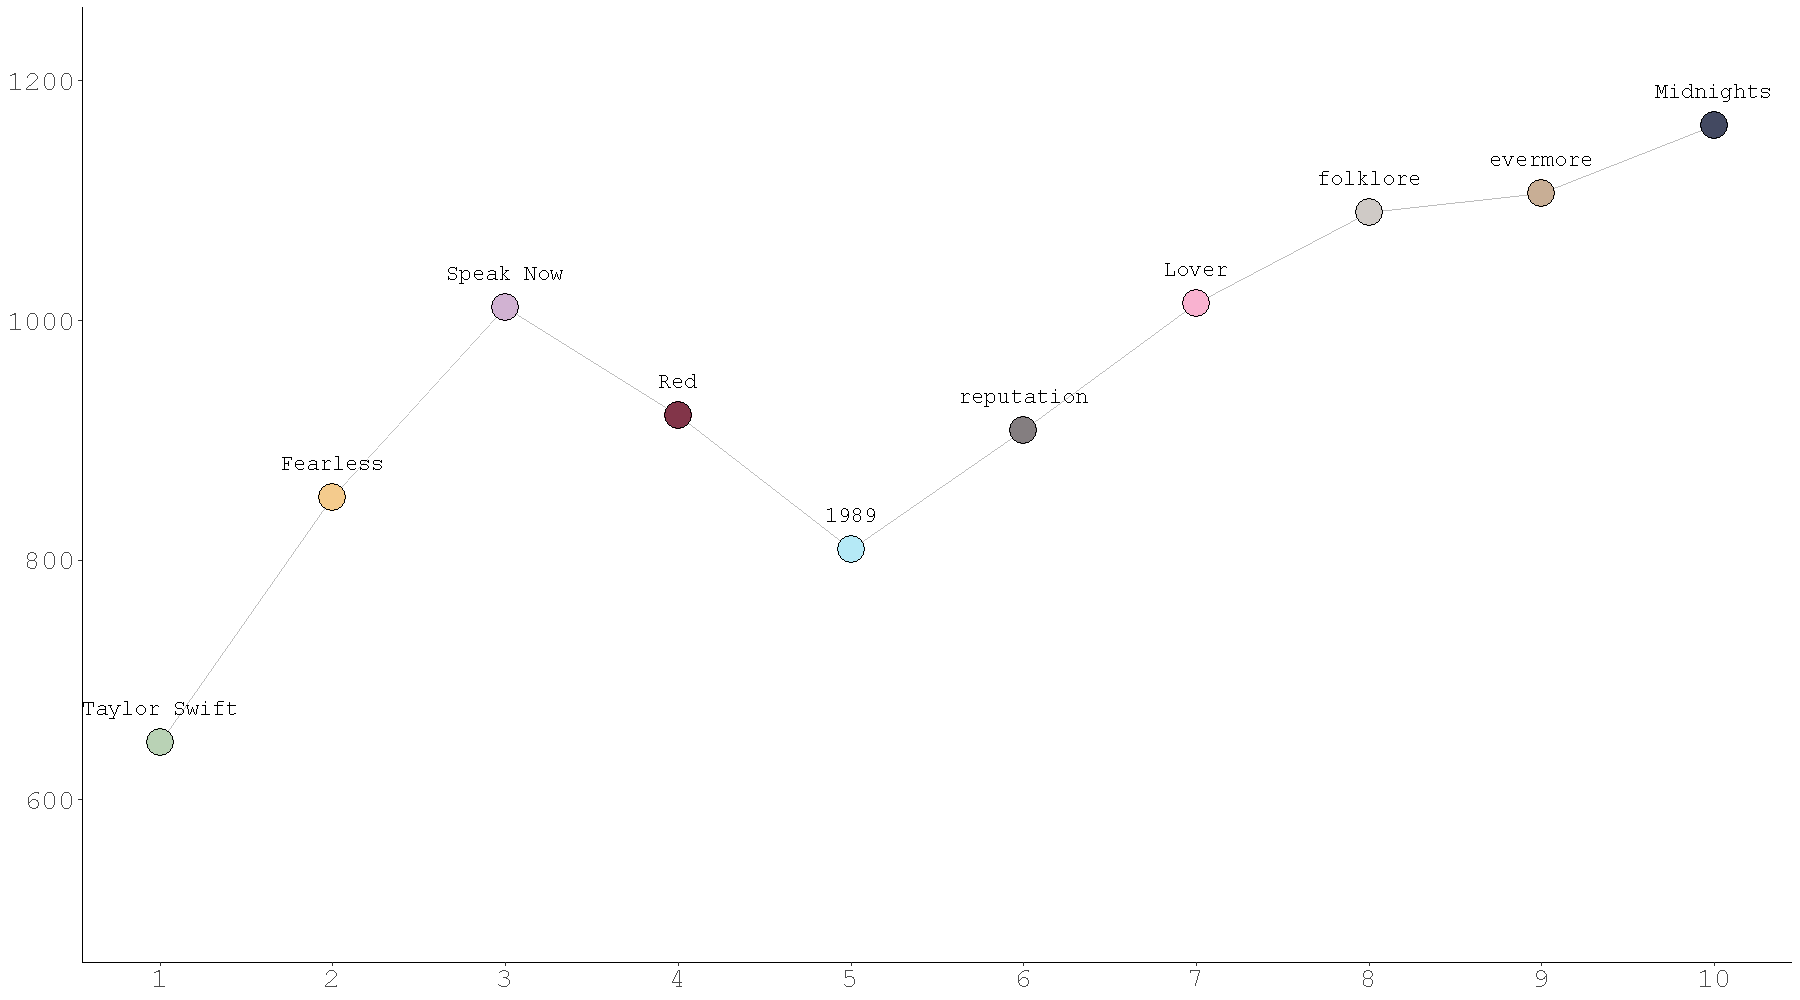

In [32]:
#8 How many distinct words does Taylor use per album?

#data for graph (number of distinct words per album)
tidy_lyrics <- data_ %>% unnest_tokens(word,lyrics)
lyrics_albums<-tidy_lyrics %>% group_by(album_name)%>%mutate(words=n_distinct(word))
lyrics_albums<-subset(lyrics_albums,select=c(album_nr, album_name, words))%>%unique()

#lineplot of distinct wordcount per album
ggplot(lyrics_albums, aes(x=as.numeric(album_nr), y=words, group=1, fill=as.factor(as.numeric(album_nr))))+
  geom_line(color="grey") +
  theme_tufte()+
  theme(axis.title = element_blank(), legend.position = 'blank',panel.grid = element_blank(),
        text=element_text(family='mono', size=25),axis.line = element_line(colour = "black"))+
  scale_fill_manual(values=c('#b9d2b5','#f4cb8d','#d1b2d2','#823549','#b5e9f6','#847e80','#f9b2d0','#cfcac6','#c8ae95','#434961'))+
  geom_text(label=lyrics_albums$album_name, vjust =-2,check_overlap = T,family='mono', size=5.5)+geom_point(shape=21, size=9)+
 scale_x_continuous(limits = c(1,10), breaks = 1:10)+scale_y_continuous(limits = c(500,1225))


#Looking at Taylor’s albums chronologically we can see a rise in the number of distinct words used per album 
#with a significant dip for 1989 which, as a pop album, has a lot of repetition in the lyrics.

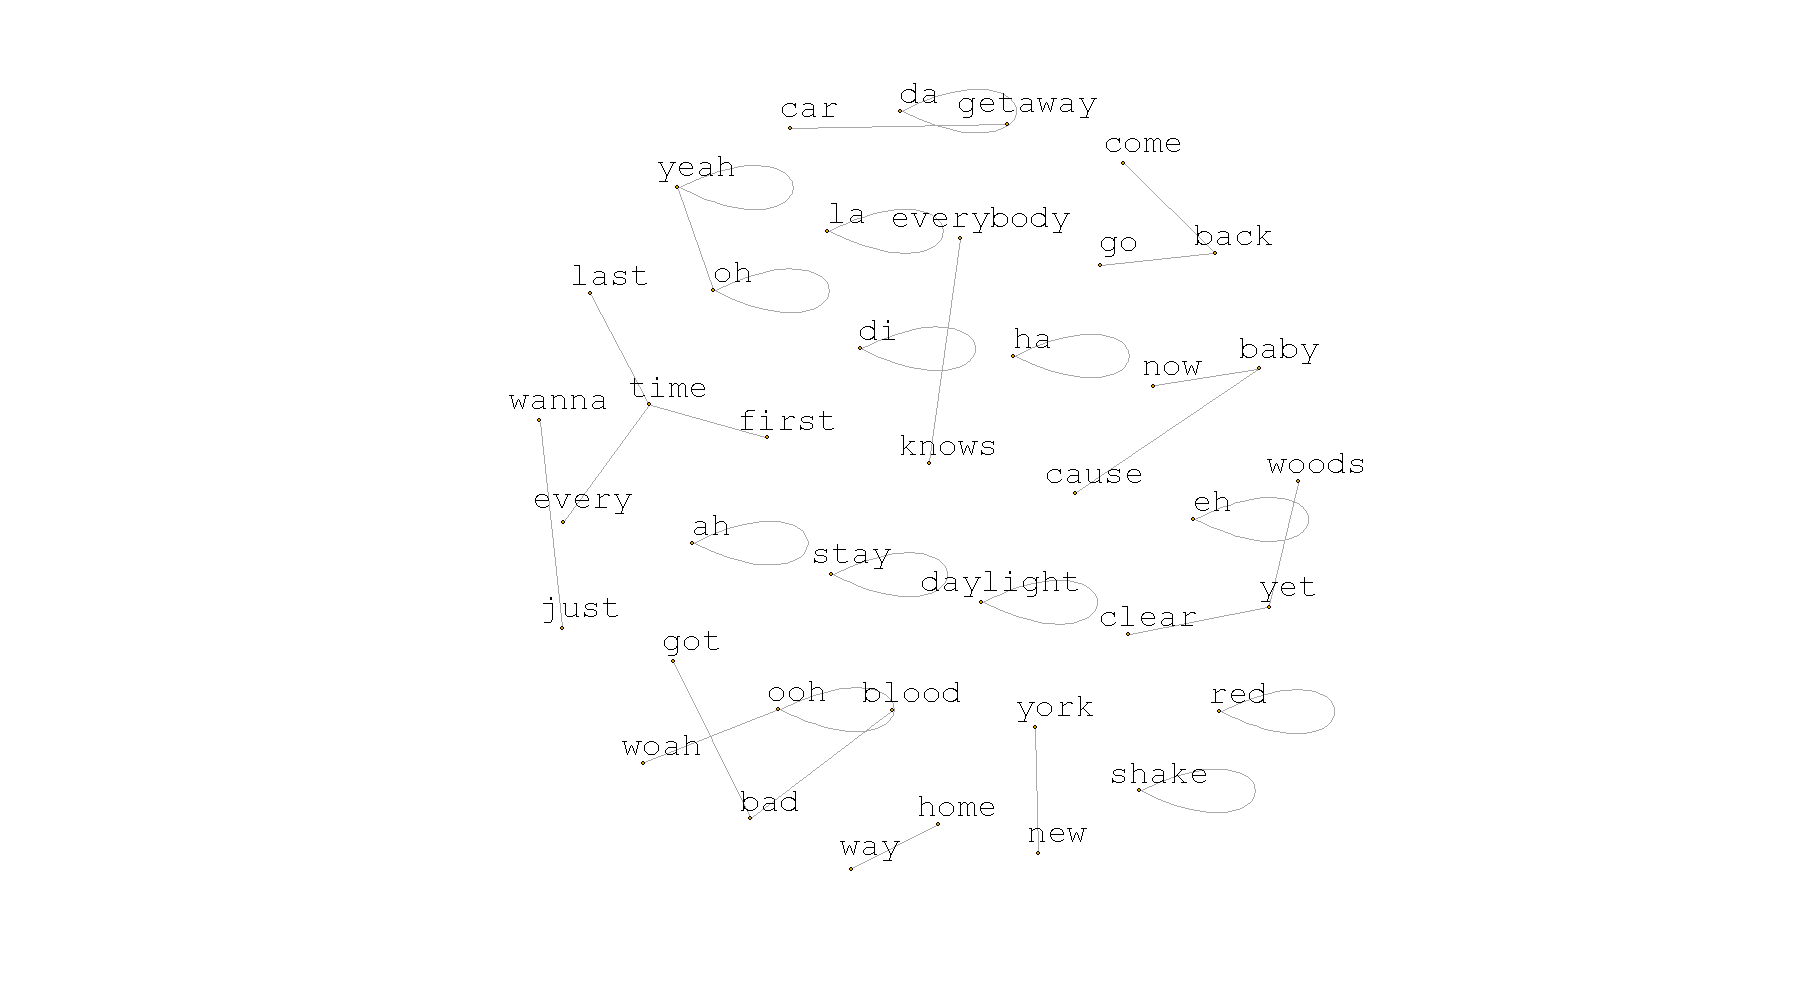

In [33]:
#9 How does Taylor lyrics network look like?

#data for graph (creating bi-grams, filtering stop words, counting bi-grams' frequency over threshold)
bi.gram.words <- data_ %>% 
  unnest_tokens(
    input = lyrics, 
    output = bigram, 
    token = 'ngrams', 
    n = 2
  ) %>% 
  filter(! is.na(bigram))
stopwords.df <- tibble(
  word = stopwords(kind = 'en'))
bi.gram.words %<>% 
  separate(col = bigram, into = c('word1', 'word2'), sep = ' ') %>% 
  filter(! word1 %in% stopwords.df$word) %>% 
  filter(! word2 %in% stopwords.df$word) %>% 
  filter(! is.na(word1)) %>% 
  filter(! is.na(word2))
bi.gram.count <- bi.gram.words %>% 
  count(word1, word2, sort = TRUE) %>% 
  rename(weight = n)
bi.gram.count <- bi.gram.count %>% 
  filter(nchar(word2)>1)%>%filter(nchar(word1)>1)%>%filter(word1!='ve')%>%filter(word1!='might')%>%filter(word1!='also')
threshold <- 20
ScaleWeight <- function(x, lambda) {
  x / lambda
}
network <-  bi.gram.count %>%
  filter(weight > threshold) %>%
  mutate(weight = ScaleWeight(x = weight, lambda = 2E3)) %>% 
  graph_from_data_frame(directed = FALSE)

#network plot
plot(
  network, 
  vertex.size = 1,
  vertex.shape=c("circle"),
  vertex.label.color = 'black', 
  vertex.label.size = 100, 
  vertex.label.family = 'mono', 
  vertex.label.cex = 2, 
  vertex.label.dist = 1,
  alpha = 50
)

#In the network analysis where we look at the words that appear together, called bi-grams, and how they interconnect. 
#We can see here ‘shake shake’, ‘new york’, ‘go back’ and ‘come back’, 
#‘everybody knows’, ‘first’, ‘last’ and ‘every’ time’.

Joining with `by = join_by(word)`
Selecting by n


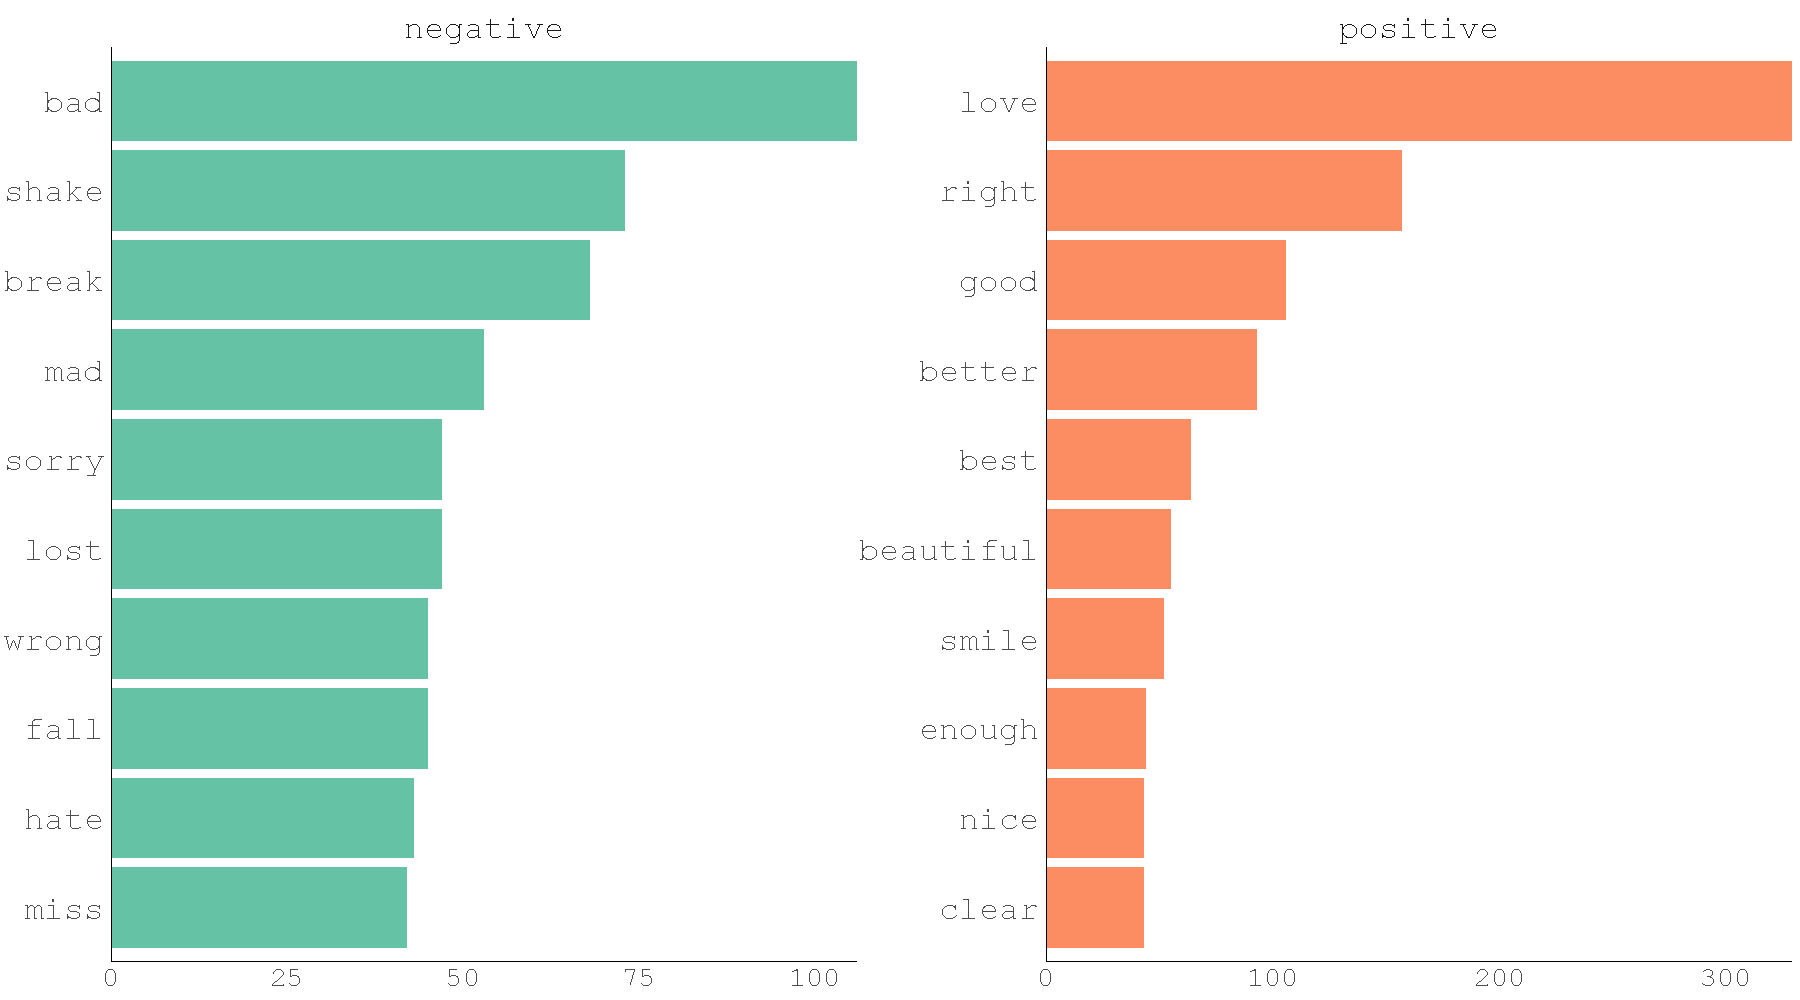

In [34]:
#10 What are the most frequent positive and negative words in Taylor's songs?

#data for graph (lyrics into word tokens, adding sentiment, limiting to top 10 most frequent)
lyric_sentiment<-tidy_lyrics %>%
  inner_join(get_sentiments('bing')) %>%
  count(word, sentiment, sort = TRUE) %>% group_by(sentiment) %>%
  filter(!word %in% c('like'))%>%
  top_n(n=10)

#plot with top 10 words with positive and negative sentiment
ggplot(lyric_sentiment, aes(x=reorder(word,n),y=n,fill=sentiment)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~sentiment,scales='free')+
  coord_flip()+theme_minimal()+scale_fill_manual(values = brewer.pal(name="Set2",n=2))+
  theme(axis.title = element_blank(), legend.position = 'blank',panel.grid = element_blank(),
        text=element_text(family='mono', size=30),axis.line = element_line(colour = "black"),axis.text.x =element_text(family='mono', size=20))+
  scale_y_continuous(expand = c(0, 0))


#Here we see frequently used words that carry a positive or negative sentiment like 'love' or 'bad'.
#However words like ‘clear’,'enough' or ‘shake’ does not neccesarily have to be positive or negative based on context
#as is shown on previous graph with the network analysis


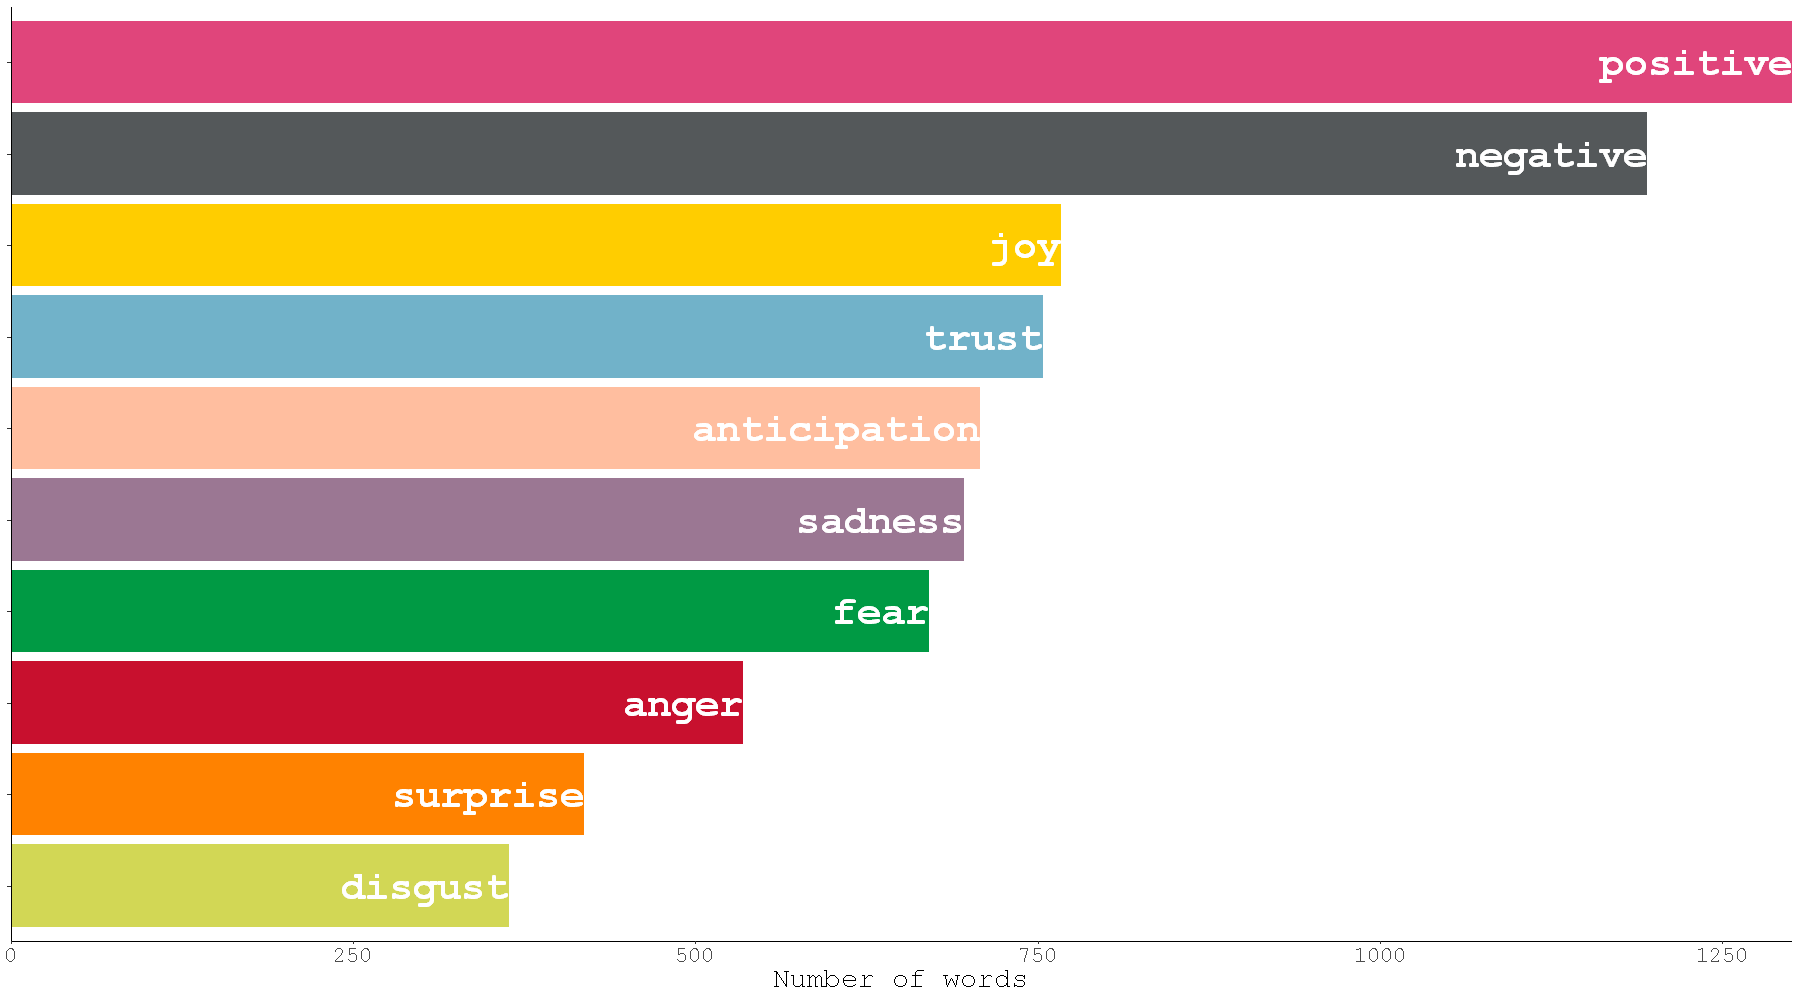

In [35]:
#11 What is the overall sentiment of Taylor's discography?

#data for graph (adding sentiment to words from lyrics)
ty_sentiment <- get_nrc_sentiment((lyrics_text))
sentimentscores<-data.frame(colSums(ty_sentiment[,]))
names(sentimentscores) <- 'score'
sentimentscores <- cbind('sentiment'=rownames(sentimentscores),sentimentscores)
rownames(sentimentscores) <- NULL

#plot with the number of words with each sentiment (with custom colors of sentiments)
ggplot(sentimentscores, aes(x=reorder(sentiment, score), y=score,fill=reorder(sentiment, score, decreasing = T)))+
  geom_col()+
  geom_text(aes(label=sentiment), fontface ="bold", family='mono', color='white',hjust = 1, size=10)+
  coord_flip()+ylab('Number of words') +xlab('')+
  scale_fill_manual(values=c('#E0457B','#54585A', '#FFCD00','#71B2C9','#FFBE9F','#9B7793','#009A44','#C8102E','#FF8200','#D2D755'))+
  theme_tufte()+theme(legend.position = 'blank',panel.grid = element_blank(),axis.title.y =element_blank(),
                        axis.text.y =element_blank() ,text=element_text(family='mono', size=20),axis.line = element_line(colour = "black"))+
  scale_y_continuous(expand = c(0, 0))

#We can see that most of the words that are present in Taylor’s lyrics have positive sentiment, 
#but it’s closely followed by the words with negative sentiment. 
#Then, we can see that Taylor uses a lot of words filled with joy, trust and anticipation, 
#but also sadness and fear. Less with anger, surprise and disgust.


Joining with `by = join_by(word)`
`geom_smooth()` using formula = 'y ~ x'


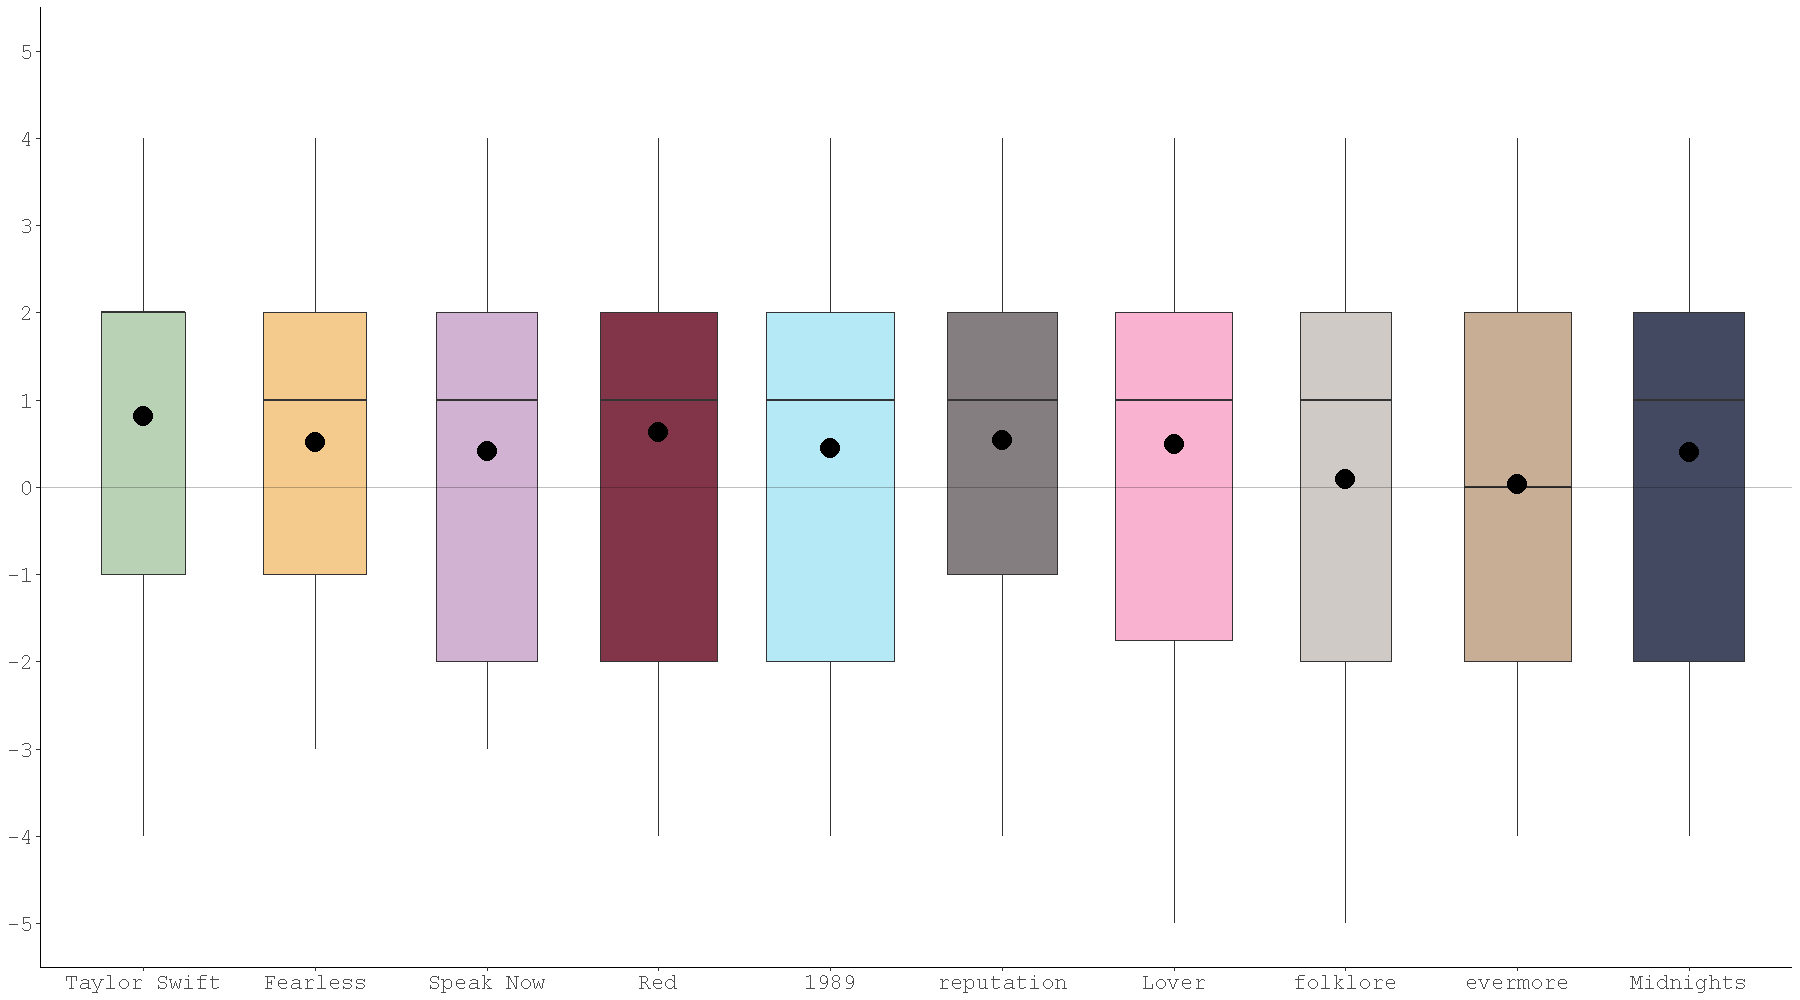

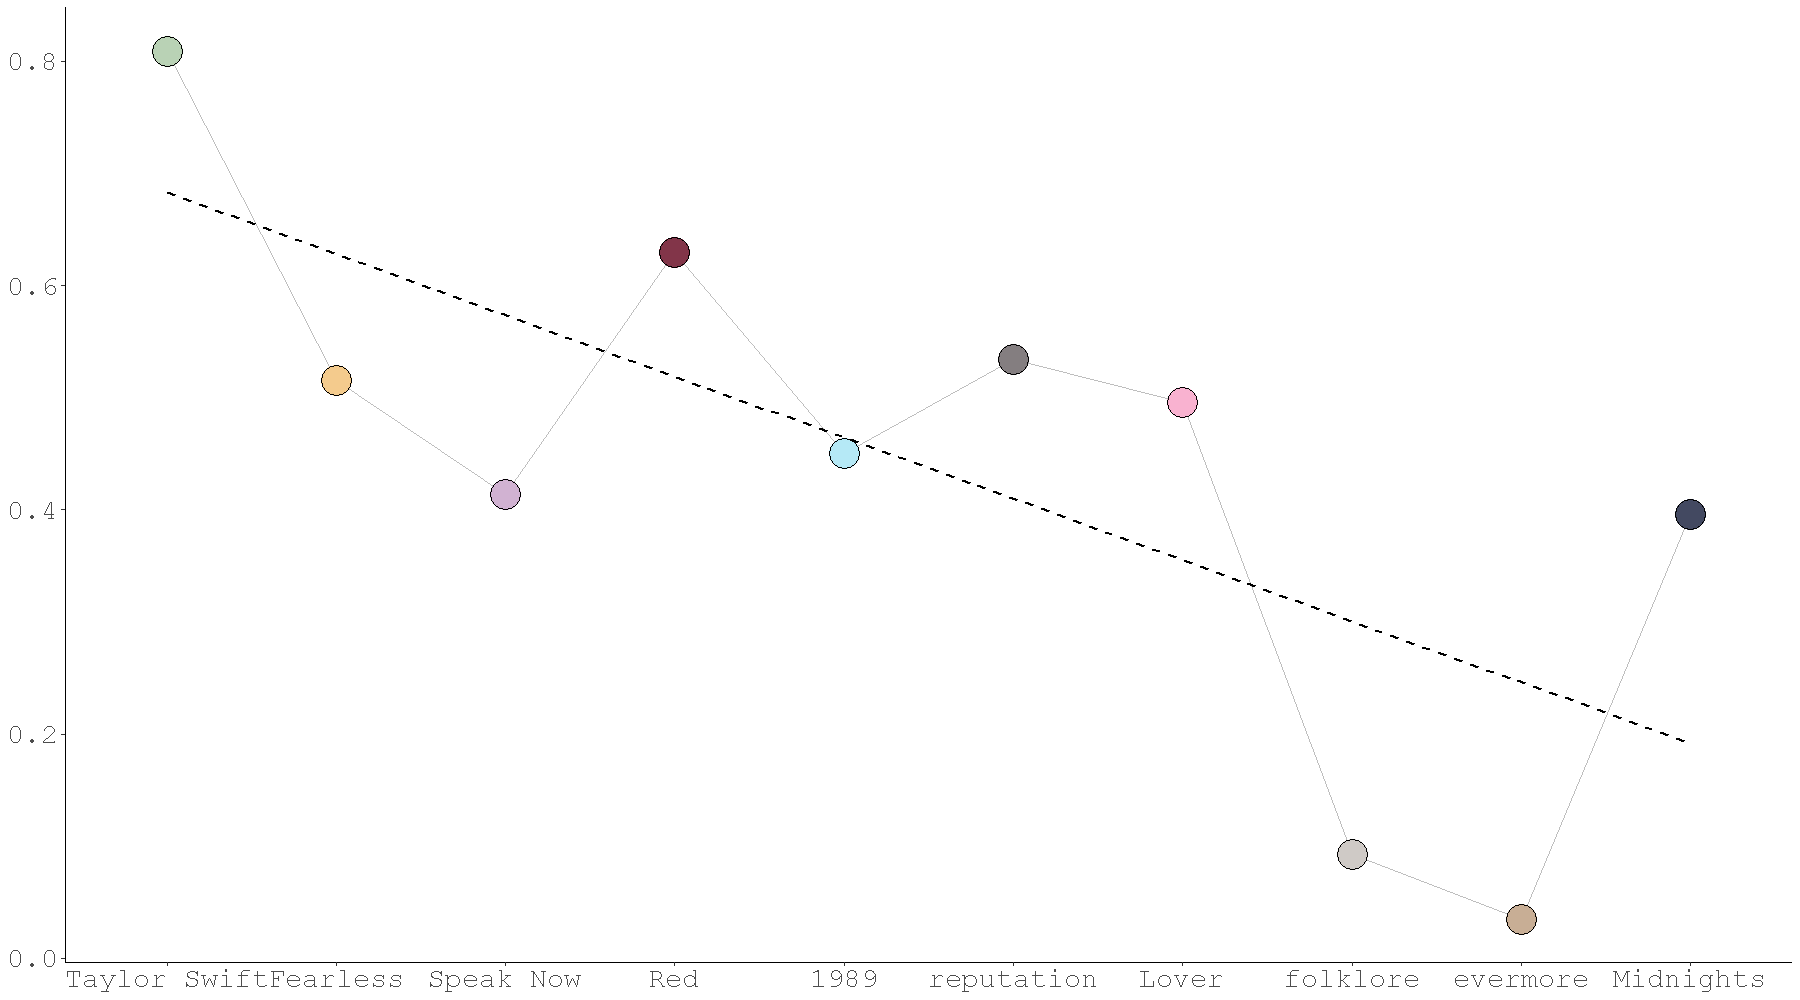

In [36]:
#12 Which album is the most positive and which one is the most negative?

#data for graphs (counting words with sentiment by album)
album_lyrics <- subset(tidy_lyrics, select=c(album_nr, album_name, word))
album_lyrics_<- album_lyrics %>%
  left_join(get_sentiments("afinn"))%>%na.omit()
album_lyrics__<- album_lyrics_%>%group_by(album_nr)%>%mutate(sentiment=mean(value))%>%
  subset(select=c(album_name, album_nr, sentiment))%>%unique()

#boxplot with each album positive and negative words count (with customized album colors and average value)
ggplot(album_lyrics_, aes(x=reorder(album_name, album_nr), y=value, fill=reorder(album_name, album_nr))) +
  geom_boxplot(varwidth = TRUE) +
  stat_summary(fun.y=mean, geom="point", shape=20, size=10)+
  theme_tufte()+theme(axis.title = element_blank(), axis.line = element_line(colour = "black"),legend.position = 'blank',panel.grid = element_blank(), text=element_text(family='mono', size=20))+
  scale_fill_manual(values=c('#b9d2b5', '#f4cb8d','#d1b2d2','#823549','#b5e9f6','#847e80','#f9b2d0','#cfcac6','#c8ae95','#434961'))+
  scale_y_continuous(limits = c(-5, 5), breaks = -5:5)+
  geom_hline(yintercept = 0, size = 0.5, color = "black", alpha=0.25)

#lineplot with each album average positive-negative score and a trend line (with customized album colors)
ggplot(album_lyrics__, aes(x=reorder(album_name, album_nr), y=sentiment, group=1,fill=as.factor(reorder(album_name, album_nr)))) +
  geom_line(color="grey")+theme_tufte()+geom_point(shape=21, size=10)+
  theme(axis.title = element_blank() ,legend.position = 'blank',axis.line = element_line(colour = "black"),
        text=element_text(family='mono', size=25))+
  geom_smooth(method = "lm", se = FALSE,color='black', linetype='dashed')+
  scale_fill_manual(values=c('#b9d2b5','#f4cb8d','#d1b2d2','#823549','#b5e9f6','#847e80','#f9b2d0','#cfcac6','#c8ae95','#434961'))


#Here we look at the box plot of lyrics scores along positive-negative sentiment scale. 
#The words that have the highest score are the most positive and the lowest – negative. 
#This shows the distribution of the words sentiment in the album, the line shows the median and the dot shows the words’ average
#We can see that Debut has the highest median and mean and folklore and evermore the lowest, 
#but overall the distribution is pretty similar among albums. 
#However if we look more closely at the average we can see a fluctuation with an overall falling trend 
#and a jump for the latest album, which gives hope for the future

Joining with `by = join_by(word)`
Selecting by n_sentiment


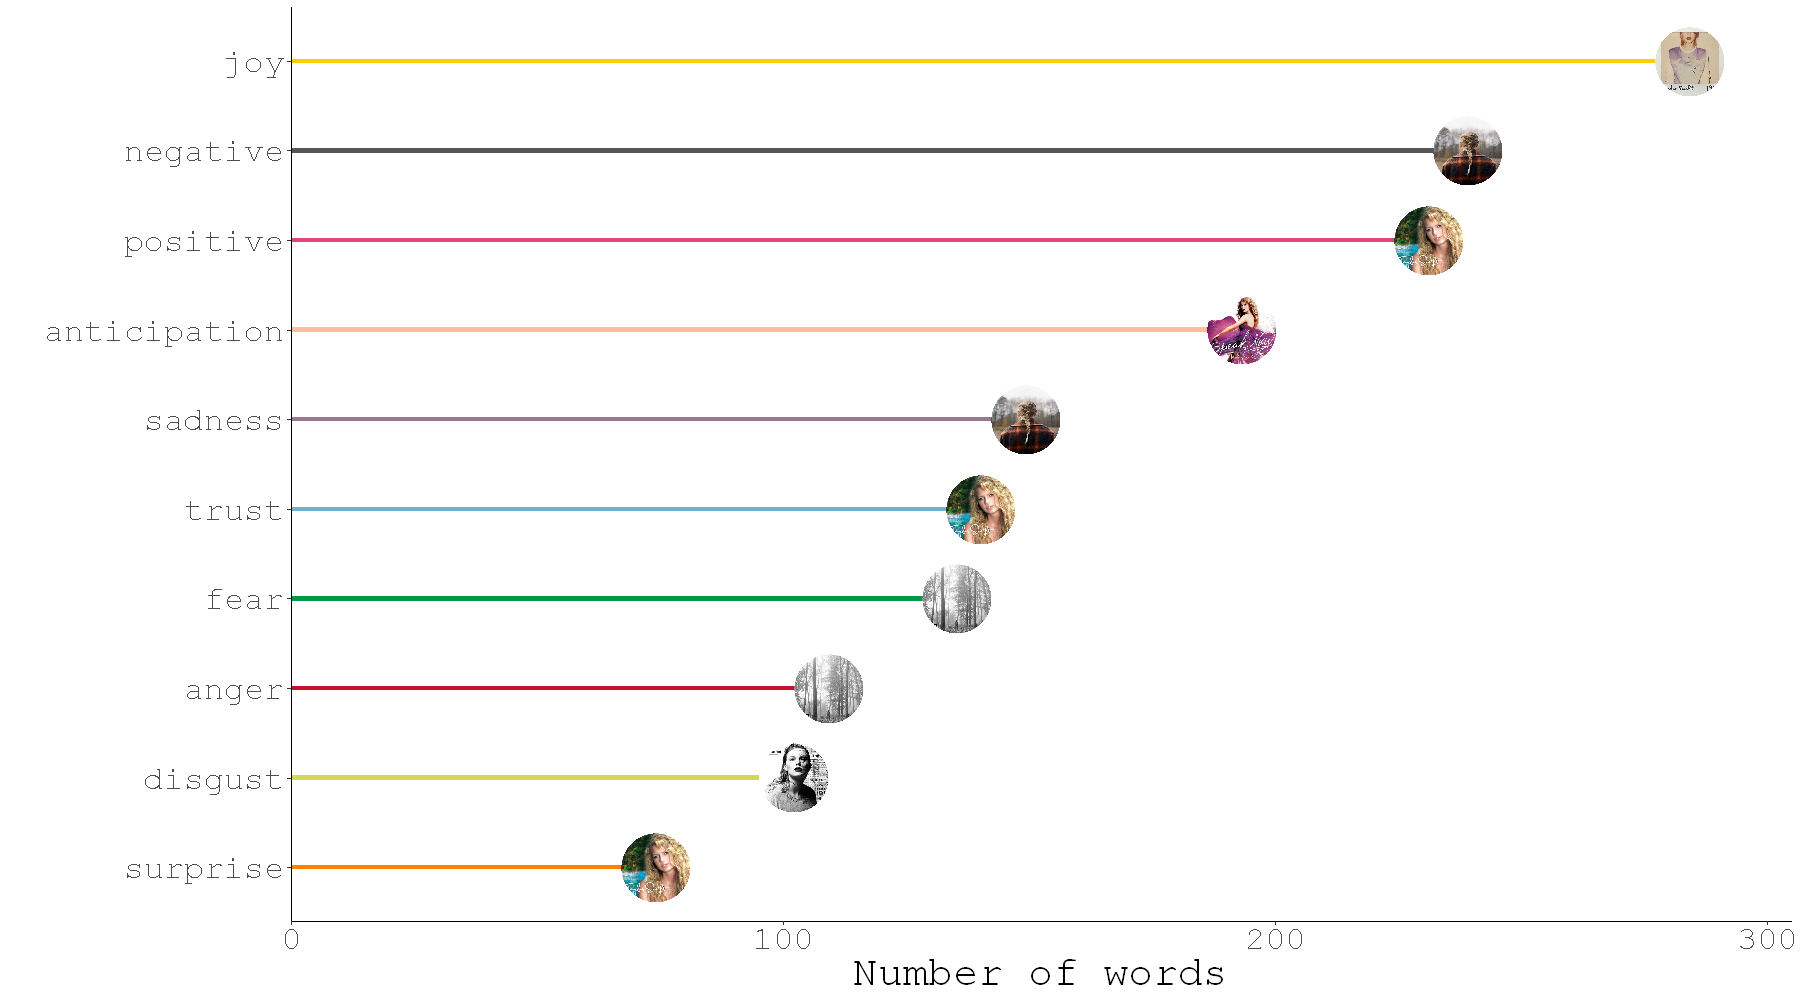

In [37]:
#13 Which album has the highest particular emotional score?

#data for graph (counting words with sentiment by album, leaving albums with highest word count of each sentiment)
album_lyrics_<- album_lyrics %>%
  left_join(get_sentiments("nrc"))%>%na.omit()
album_lyrics__<- album_lyrics_%>%group_by(album_nr)%>%mutate(n_words=sum(album_nr)/album_nr)%>%
  count(album_nr, album_name, n_words,sentiment)%>%mutate(n_sentiment=n/n_words)%>%
  group_by(sentiment)%>%
  top_n(n=1)%>%na.omit()

#adding pictures of albums
d <- data.frame(
  n = album_lyrics__$n,
  sentiment=album_lyrics__$sentiment,
  album = album_lyrics__$album_name,
  image = c(
    "https://taylorswiftalbumsinorder.info/wp-content/uploads/2023/06/Taylor-Swift-Album-Images.jpg",
    "https://taylorswiftalbumsinorder.info/wp-content/uploads/2023/06/Taylor-Swift-Album-Images.jpg",
    "https://taylorswiftalbumsinorder.info/wp-content/uploads/2023/06/Taylor-Swift-Album-Images.jpg",
    "https://taylorswiftalbumsinorder.info/wp-content/uploads/2023/06/Taylor-Swift-Speak-Now-Album-Images.jpg",
    "https://taylorswiftalbumsinorder.info/wp-content/uploads/2023/06/Taylor-Swift-1989-Album-Images.jpg",
    "https://taylorswiftalbumsinorder.info/wp-content/uploads/2023/06/Taylor-Swift-Reputation-Album-Images.jpg",
    "https://taylorswiftalbumsinorder.info/wp-content/uploads/2023/06/Taylor-Swift-Folklore-Album-Images.jpg",
    "https://taylorswiftalbumsinorder.info/wp-content/uploads/2023/06/Taylor-Swift-Folklore-Album-Images.jpg",
    "https://taylorswiftalbumsinorder.info/wp-content/uploads/2023/06/Taylor-Swift-Evermore-Album-Images.jpg",
    "https://taylorswiftalbumsinorder.info/wp-content/uploads/2023/06/Taylor-Swift-Evermore-Album-Images.jpg"
  ))

d <- d%>%mutate(images_cropped = circle_crop(image))

#plot with albums with highest word count of each sentiment with picture of each album cover and custom colors of sentiments
ggplot(d, aes(reorder(sentiment, n), n, fill=reorder(sentiment, n, decreasing=T))) +geom_col(width = 0.05)+ 
  geom_image(aes(image=images_cropped), size=.075, nudge_y=5)+
  theme_tufte()+coord_flip()+ylab('Number of words') +xlab('')+
  scale_fill_manual(values=c('#FFCD00','#54585A','#E0457B' ,'#FFBE9F','#9B7793','#71B2C9','#009A44','#C8102E','#D2D755','#FF8200'))+
  theme(legend.position = 'blank',panel.grid = element_blank(),
        text=element_text(family='mono', size=30),axis.line = element_line(colour = "black"))+
  scale_y_continuous(expand = c(0, 0), limit=c(0,305))

#Looking at the top we have 1989 with the most words filled with joy, 
#then evermore with negative but also sad emotions, 
#Taylor Swift or Debut, which is Taylor’s first album has the most positive, trustful and surprised words. 
#Then Speak Now with anticipation, which is fitting 
#and folklore with fear and anger and reputation with disgust.
#All of that makes sense to me

Joining with `by = join_by(word)`
Selecting by n_sentiment


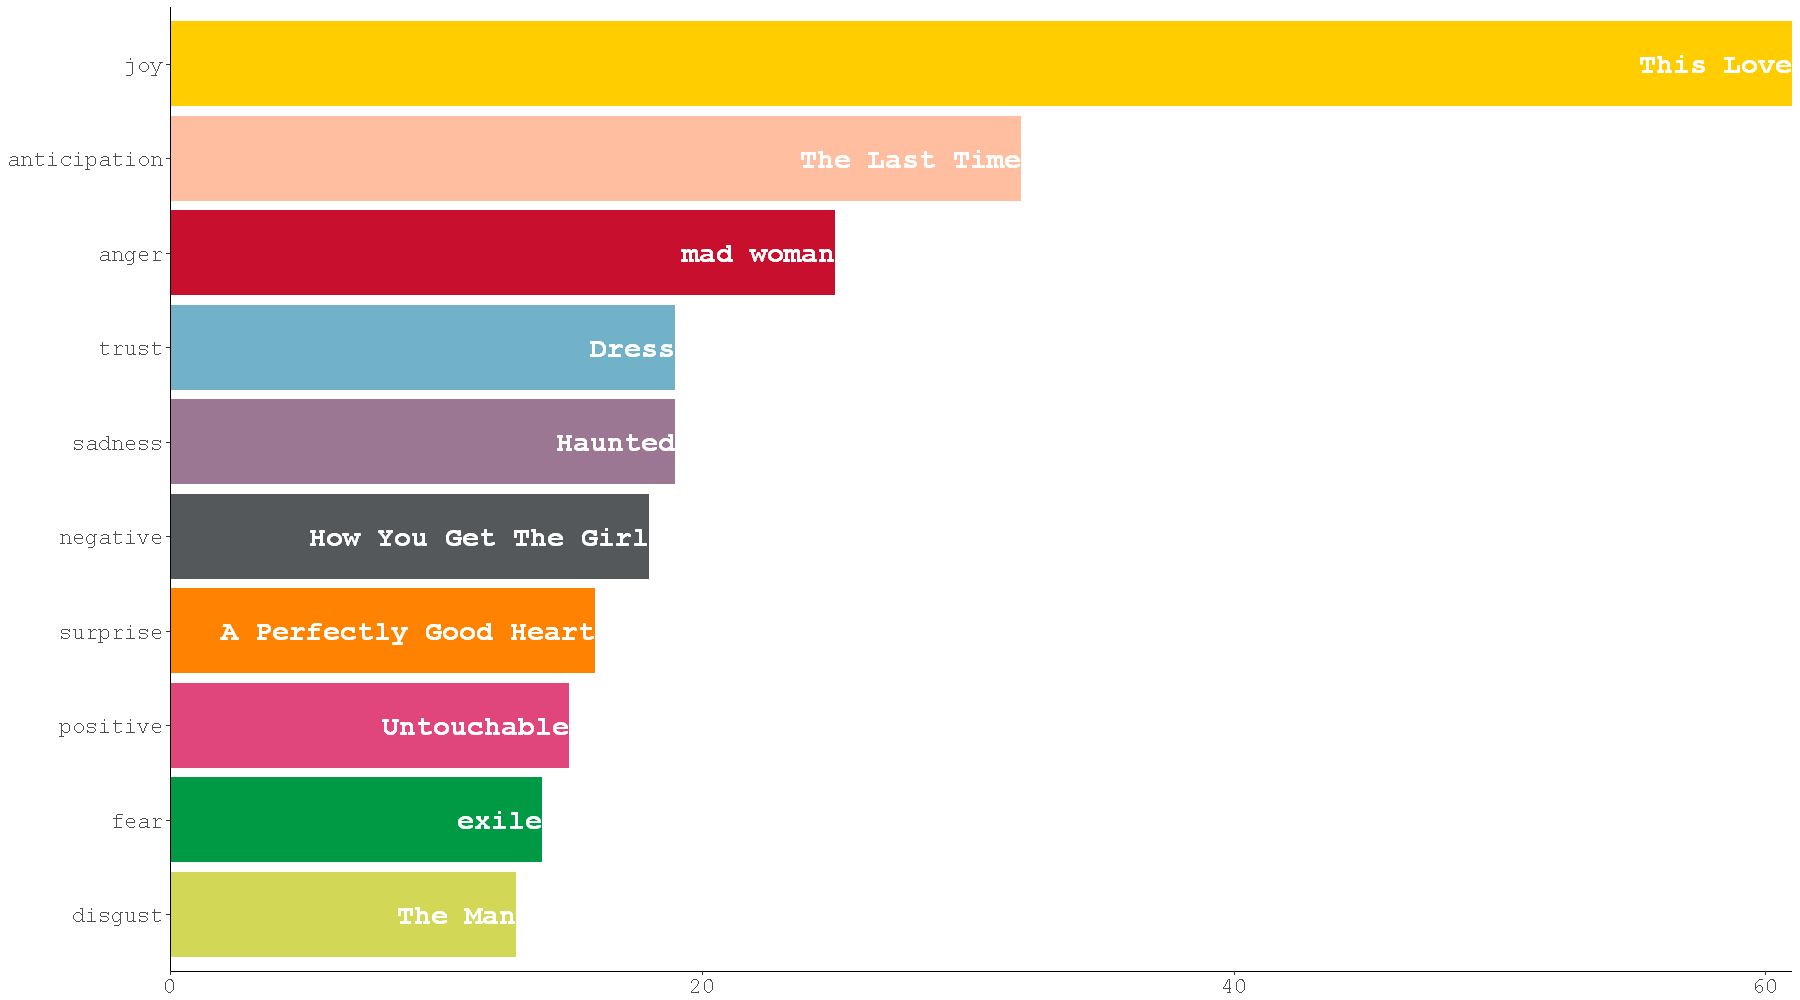

In [38]:
#14 Which song has the highest particular emotional score?

#data for graph (counting words with sentiment by song, leaving songs with highest word count of each sentiment)
song_lyrics <- subset(tidy_lyrics, select=c(album_nr, album_name, track_name, word))
song_lyrics_<- song_lyrics %>%
  left_join(get_sentiments("nrc"))%>%na.omit()
song_lyrics__<- song_lyrics_%>%group_by(track_name)%>%mutate(n_words=sum(album_nr)/album_nr)%>%
  count(album_nr, album_name,track_name ,n_words,sentiment)%>%mutate(n_sentiment=n/n_words)%>%
  group_by(sentiment)%>%
  top_n(n=1)%>%na.omit()%>% filter(n>10)

#plot with albums with highest word count of each sentiment with custom colors of sentiments
ggplot(song_lyrics__, aes(reorder(sentiment, n), n, fill=reorder(sentiment, n, decreasing=T))) +geom_col()+
  theme_tufte()+coord_flip()+
  theme(axis.title = element_blank(), legend.position = 'blank',panel.grid = element_blank(),
        text=element_text(family='mono', size=20),axis.line = element_line(colour = "black"))+scale_y_continuous(expand = c(0, 0))+
  scale_fill_manual(values=c('#FFCD00','#FFBE9F','#C8102E','#9B7793','#71B2C9','#54585A','#FF8200','#E0457B','#009A44','#D2D755'))+
  geom_text(label=song_lyrics__$track_name,check_overlap = F,hjust=1,color='white',family='mono', size=7, fontface ="bold")

#Here we see songs with the highest relative amount of words with specific sentiment 
#or we can call it the highest emotional score.
#We have: anger for mad women, disgust for The Man, joy with This Love and fear with exile 
#all of them fit with the song's vibes.
#For others, their lyrics sentiment suits less with their musical emotional score, which underlines the importance of context.

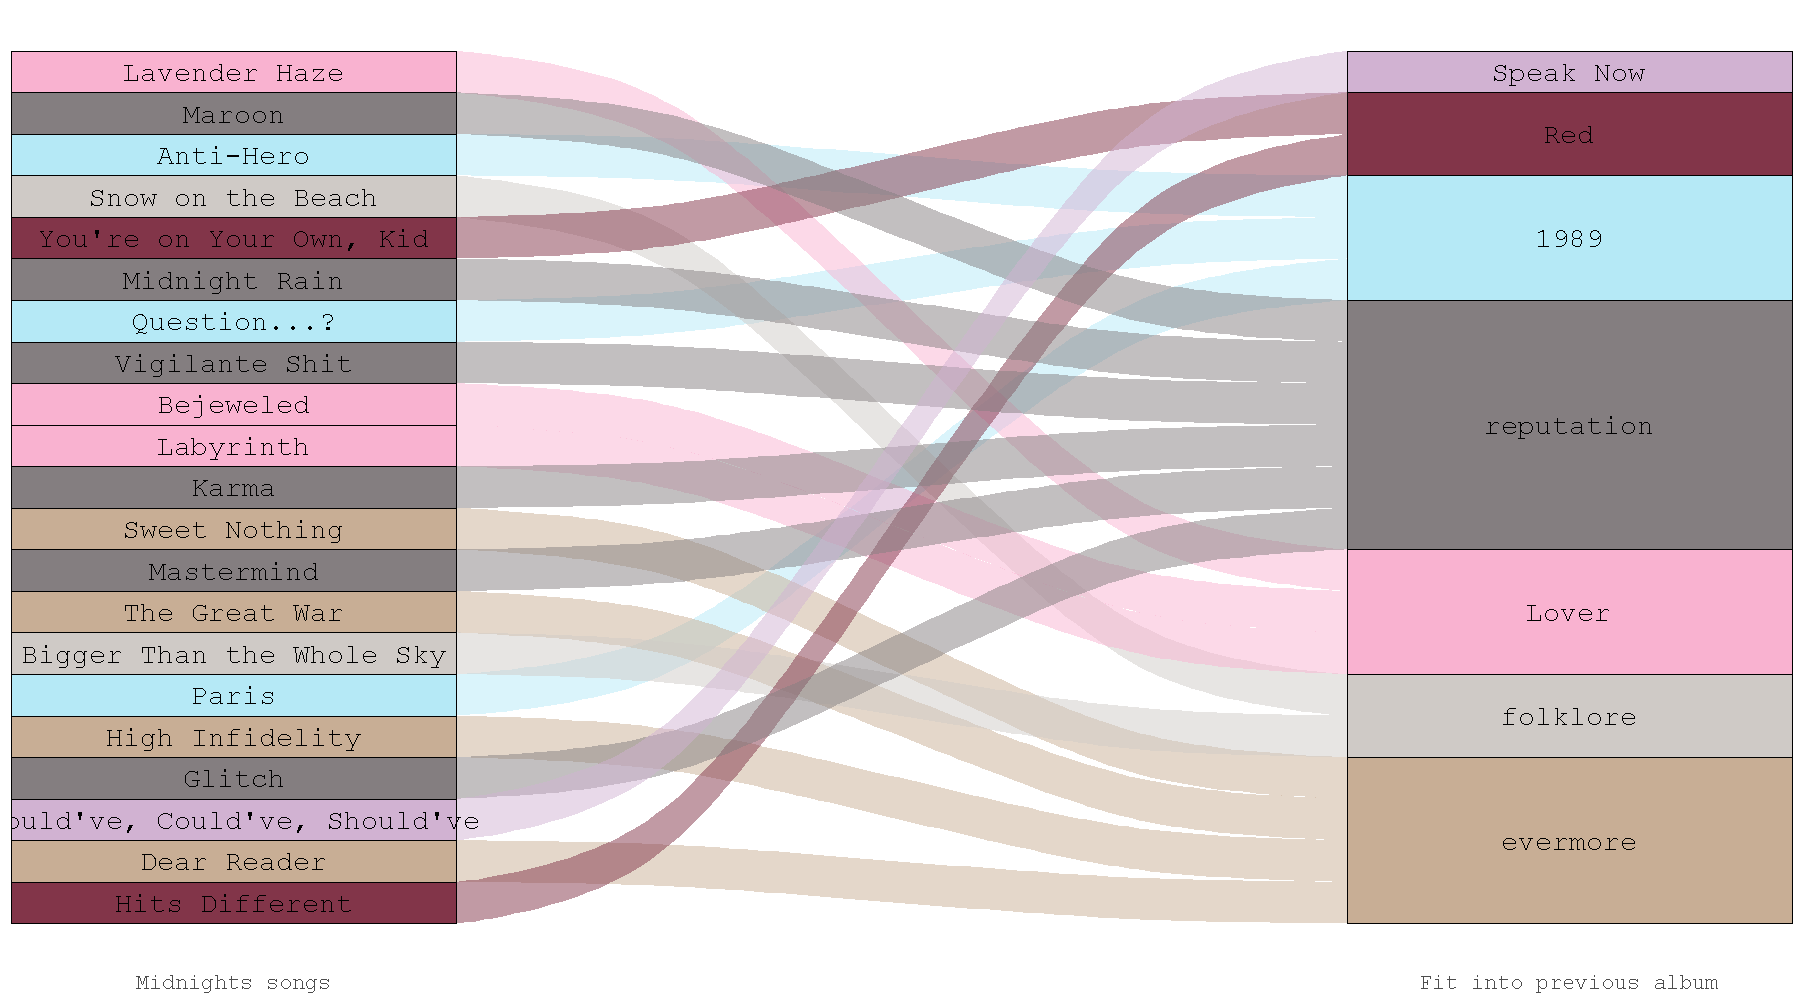

In [39]:
#15 How does Midnights fit into Taylor's other albums?

#dataset
d <- data.frame(
  nr=1:21,
  title=c("Lavender Haze","Maroon","Anti-Hero", "Snow on the Beach","You're on Your Own, Kid",
          "Midnight Rain", "Question...?", "Vigilante Shit", "Bejeweled", "Labyrinth",
          "Karma" , "Sweet Nothing", "Mastermind", "The Great War", "Bigger Than the Whole Sky", 
          "Paris", "High Infidelity" , "Glitch", "Would've, Could've, Should've", "Dear Reader",
          "Hits Different"),
  album1 = c(rep("Midnights",21)),
  album2 = c("Lover","reputation","1989","folklore","Red","reputation","1989",
             "reputation","Lover","Lover","reputation","evermore",
             "reputation","evermore","folklore","1989","evermore","reputation",
             "Speak Now","evermore","Red"),
  fit = c(rep(1,21)),
  album_nr=c(7,6,5,8,4,6,5,6,7,7,6,9,6,9,8,5,9,6,3,9,4)
)

#parallel plot
ggplot(data = d,
       aes(axis1 = reorder(title,nr), axis2 = reorder(album2,album_nr), y = fit)) +
  geom_alluvium(aes(fill = reorder(album2,fit))) +
  scale_fill_manual(values=c("#b5e9f6","#c8ae95","#cfcac6","#f9b2d0","#823549","#847e80","#d1b2d2"))+
  geom_stratum(aes(fill = reorder(album2,fit))) +
  geom_text(stat = "stratum", aes(label = after_stat(stratum)),family='mono', size=7) +
  theme_tufte()+theme(axis.title = element_blank(),legend.position = 'blank',panel.grid = element_blank(),
                            text=element_text(family='mono', size=20), axis.text.y = element_blank(), axis.ticks = element_blank())+
  scale_x_discrete(limits = c("Midnights songs","Fit into previous album"), expand = c(0, 0))


#The 'Midnights concept was supposed to be based on sleepless night through Taylor's life, 
#including the time when she was recording and releasing previous albums. 
#With that there is a lot of speculation on how songs from Midnights fit into her other albums 
#and the consensus online is as shown here on this parallel chart, with most of them falling into reputation, 
#which, as it was the most tumultuous time in her life, makes sense.


#Thank you for looking at my work, I hope you've learned more about Taylor 
#and it will be fun to look back at this analysis after Taylor realises her new album
#The Tortured Poets Department